### Este é um projeto para a matéria "**Algoritmos de Inteligência Artificial para classificação**" da Infnet.
### Feito 100% por **Everton Vanoni Fernandes** com o conhecimento adquirido nas aulas ao vivo, no curso de Kaggle, e pesquisas no google em expecificos pontos.

In [148]:
# Importações que vamos usar neste arquivo.
from kagglehub import KaggleDatasetAdapter
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer

### 1. Carregamento do data set

Para facilitar, e não precisar do arquivo de dataset baixado no mesmo local deste arquivo, ou usar o drive que necessita de um login, vamos usar o kagglehub.

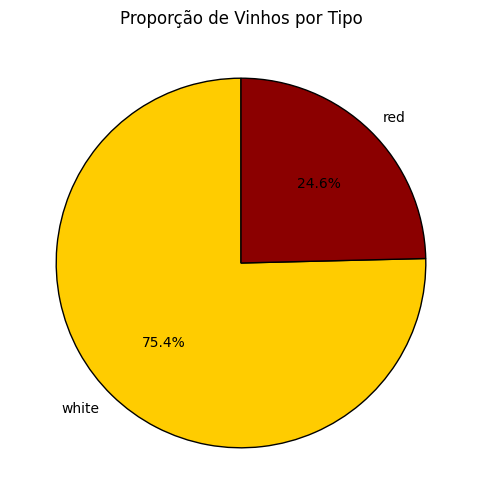

In [149]:
file_path = "winequalityN.csv"

df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "rajyellow46/wine-quality", file_path)

# Cria um gráfico pizza apenas para visualizar o resultado. E mostrar a porcentagem de cada tipo de vinho.
wine_counts = df['type'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(
    wine_counts,
    labels=wine_counts.index,  # Usa os próprios tipos de vinho como rótulos
    autopct='%1.1f%%',
    colors=['#ffcc00', '#8b0000'],  # Define cores para vinhos brancos e tintos
    startangle=90,
    wedgeprops={'edgecolor': 'black'}
)
plt.title("Proporção de Vinhos por Tipo")
plt.show()

### 2. Filtrar apenas por vinhos do tipo "branco"

Este dataset contem 75.4% de vinhos brancos, e ~24.6% de vinhos vermelhos, mas só estamos interessados nos vinhos do tipo branco, então vamos filtrar na celula abaixo.

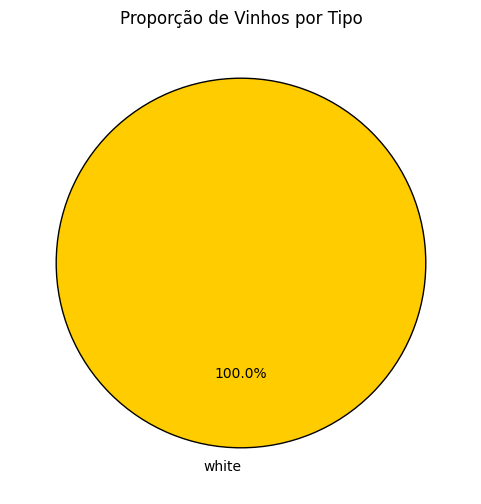

In [150]:
df_white_wine = df[df['type'] == 'white']


# Cria um gráfico pizza apenas para visualizar o resultado do filtro.
white_wine_counts = df_white_wine['type'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(
    white_wine_counts,
    labels=white_wine_counts.index,  # Usa os próprios tipos de vinho como rótulos
    autopct='%1.1f%%',
    colors=['#ffcc00', '#8b0000'],  # Define cores para vinhos brancos e tintos
    startangle=90,
    wedgeprops={'edgecolor': 'black'}
)
plt.title("Proporção de Vinhos por Tipo")
plt.show()

### 3. Adicionando a variavel "opinion"

Temos o seguinte requisito para este projeto:

> criar variavel “opinion” onde o valor deve ser 0 caso o “quality” seja menor ou igual a 5, se nao deve ser 1

Visto isso, vamos adicionar essa uma nova coluna ao dataset, onde:
- Se a qualidade do vinho (quality) for menor ou igual a 5, opinion será 0 (ruim).
- Se a qualidade for maior que 5, opinion será 1 (bom).

<ipython-input-151-81d0cf1c8c93>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_white_wine['opinion'] = (df_white_wine['quality'] >= 5).astype(int)


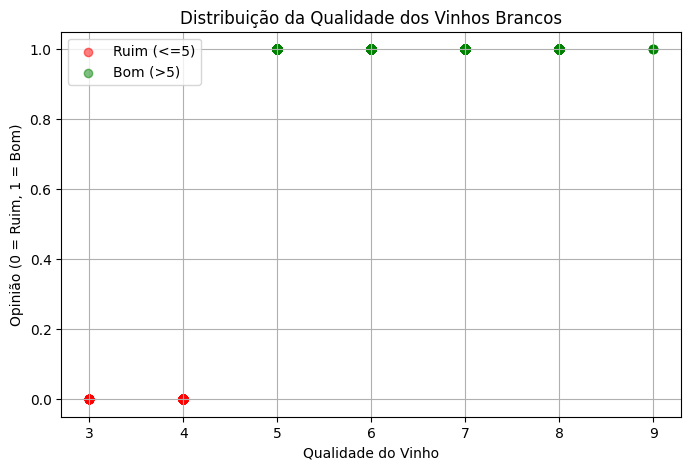

In [151]:
df_white_wine['opinion'] = (df_white_wine['quality'] >= 5).astype(int)

# Cria um gráfico de dispersão onde:
# - Vinhos "ruins" (opinion = 0) serão vermelhos
# - Vinhos "bons" (opinion = 1) serão verdes
plt.figure(figsize=(8, 5))
plt.scatter(df_white_wine['quality'][df_white_wine['opinion'] == 0], df_white_wine['opinion'][df_white_wine['opinion'] == 0], color='red', label='Ruim (<=5)', alpha=0.5)
plt.scatter(df_white_wine['quality'][df_white_wine['opinion'] == 1], df_white_wine['opinion'][df_white_wine['opinion'] == 1], color='green', label='Bom (>5)', alpha=0.5)
plt.xlabel('Qualidade do Vinho')
plt.ylabel('Opinião (0 = Ruim, 1 = Bom)')
plt.title('Distribuição da Qualidade dos Vinhos Brancos')
plt.legend()
plt.grid(True)
plt.show()

### 4. Analisando as variáveis presentes na base

Temos o seguinte requisito para o projeto:

> Descreva as variáveis presentes na base. Quais são as variáveis? Quais são os tipos de variáveis (discreta, categórica, contínua)? Quais são as médias e desvios padrões?

Vou estar respondendo cada pergunta junto com um "print" na celula abaixo.


In [152]:
# Quais são as variáveis?
# Como podemos ver no print abaixo, as variáveis sao:
# - type: Tipo do vinho
# - fixed acidity: Acidez fixa
# - volatile acidity: Acidez volátil
# - citric acid: Ácido cítrico
# - residual sugar: Açúcar residual
# - chlorides: Cloretos
# - free sulfur dioxide: Dióxido de enxofre livre
# - total sulfur dioxide: Dióxido de enxofre total
# - density: Densidade
# - pH: pH do vinho
# - sulphates: Sulfatos
# - alcohol: Teor alcoólico
# - quality: Qualidade do vinho (nota de 0 a 10)
# - opinion: Variável criada para classificação (0 = ruim, 1 = bom)
print("Colunas do dataset:", df_white_wine.columns.tolist())

# Quais são os tipos de variáveis (discreta, categórica, continuas)?
# categórica:
# - type: Representa o tipo de vinho (red ou white), ou seja, e categorica
# - opinion: Criamos essa coluna nova para classificarmos se tem qualidade ou nao, ou seja, e categorica tambem
# discreta:
# - quality: Representa notas de 0 a 10, sempre numeros inteiros e contaveis
# continuas:
# Todas as outras variaveis, sao numeros quebrados, ou podemos dizer decimais, do tipo float
print("\nTipos das variáveis:\n", df_white_wine.dtypes)

# Quais são as médias e desvios padrões?
# Podemos estar verificando as respostas para essa pergunta no print abaixo,
# para verificar as médias podemos estar olhando para a variavel "mean", e
# para verificar o desvio padrao olhamos para a variavel "std".
print("\nEstatísticas das variáveis numéricas:\n", df_white_wine.describe())

Colunas do dataset: ['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'opinion']

Tipos das variáveis:
 type                     object
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
opinion                   int64
dtype: object

Estatísticas das variáveis numéricas:
        fixed acidity  volatile acidity  citric acid  residual sugar  \
count    4890.000000       4891.000000  4896.000000     4896.000000   
mean        6.855532          0.278252     0.334250        6.393250   
std         0.843808          0.100811  

### 5. Etapas necessárias para criar um modelo de classificação eficiente

#### Antes de começar a modelagem, é essencial entender:

- O objetivo do modelo: prever se um vinho tem boa qualidade (opinion = 1) ou não (opinion = 0)
- O significado das variáveis e sua relação com a variável alvo (opinion)
- Possíveis desafios como desbalanceamento de classes, outliers e correlação entre variáveis

#### Pré-processamento dos Dados

1. Tratamento de valores faltantes

Precisamos fazer o tratamento de valores faltantes, para casos onde o valor e null, caso tenha valores null, precisamos remover, ou preencher com a media, mediana ou outro metodo.

2. Tratamento de Outliers

Precisamos identificar valores extremos nas variaveis continuas usando graficos como boxplots, e para resolver podemos fazer a remocao dos outliers ou a normalizacao dos dados.

#### Divisao entre conjunto de treino e teste

O dataset deve ser dividido em treino, e teste para avaliar o desempenho do modelo.

#### Escolha do modelo

Com os dados preparados, podemos testar diferentes algoritmos de classificacao.
Para este projeto iremos estar testando com os mesmos dados, os seguintes modelos:

- Regressão Logística
- Árvores de Decisão
- SVM (Support Vector Machine)

#### Avaliação do Modelo

Apos treinar o modelo, precisamos avaliar sua performance das seguintes formas:

1. Usar "confusion_matrix" para saber a Matriz de Confusao
2. Usar "accuracy_score" para saber a Acurácia
3. Usar "classification_report" para outras metricas importantes como precisao, recall e f1-score

#### Ajuste de Hiperparâmetros

Se os resultados nao forem satisfatorios, podemos ajustar os params do modelo usando tecnicas como:

- Grid Search: Testa combinacoes de parametros para encontrar os melhores valores.
- Random Search - Testa valores aleatorios e pode ser mais rapido.


#### Implementação e Otimização:

Se o modelo estiver satisfatorio, podemos aplicar o modelo em um pipeline para facilitar o uso em producao, e apos isso so salvar o modelo de alguma forma, como por exemplo usando o "joblib.dump(model, "wine_model.pk1")".





### 6. Preparação das variaveis


In [153]:
# separarando em x e y
target = 'opinion'
x = df_white_wine.drop([target], axis=1)
y = df_white_wine[[target]]

In [154]:
# separando variáveis numéricas e categóricas
cat = ['type']
num = [col for col in x.columns if col not in cat]

In [155]:
# separando treino e teste - com estratificação
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y)

### 7. Criação dos modelos

Vamos comecar a colocar a mão na massa criando os modelos, que vai ser o de regressão logística, arvore de decisão e SVM usando um modelo de validação cruzada estratificada com k-folds (k=10) para realizar a classificação de cada um.

#### Requisitos para cada modelo:

Precisamos calcular para a base de teste:

- [x]  i. a média e desvio da acurácia dos modelos obtidos;
- [x]  ii. a média e desvio da precisão dos modelos obtidos;
- [x]  iii. a média e desvio da recall dos modelos obtidos;
- [x]  iv. a média e desvio do f1-score dos modelos obtidos.




In [156]:
# criando um pipe de processamento
preprocessor = ColumnTransformer([
    ('category', OneHotEncoder(drop='first'), cat),
    ('numeric', RobustScaler(), num)
])

In [157]:
# criando os pipes para cada modelo
logistic_regression_pipe = Pipeline([
    ('transformer', preprocessor),
    ('imputer', SimpleImputer(strategy='mean')), # Trata valorer NaN
    ('selector', SelectKBest(f_classif)),
    ('model', LogisticRegression(solver='saga'))
])

decision_tree_pipe = Pipeline([
    ('transformer', preprocessor),
    ('imputer', SimpleImputer(strategy='mean')), # Trata valorer NaN
    ('selector', SelectKBest(f_classif)),
    ('model', DecisionTreeClassifier(random_state=5))
])

svc_pipe = Pipeline([
    ('transformer', preprocessor),
    ('imputer', SimpleImputer(strategy='mean')), # Trata valorer NaN
    ('selector', SelectKBest(f_classif)),
    ('svc', SVC(random_state=2, probability=True))
])

In [158]:
# configurando o espaço de busca
params_grid_logistic_regression = {
    'model__penalty': ['l1', 'l2', 'elasticnet'],
    'model__C': [0.001, 0.01, 0.1, 1, 10],
    'model__l1_ratio': [0.25, 0.5, 0.75],
    'model__class_weight': ['balanced', None],
    'selector__k': range(1, 11)
}

params_grid_decision_three = {
    'model__max_depth': range(2, 11),
    'model__criterion': ['gini', 'entropy'],
    'model__class_weight': ['balanced', None],
    'selector__k': range(1, 11)
}

params_grid_svc = {
    'selector__k': range(1, 11)
}

In [159]:
# configuranco o amostrador - estratificado
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=5)

In [160]:
# configura um buscador aleatório - logistic regression
random_search_logistic_regression = RandomizedSearchCV(
    estimator=logistic_regression_pipe,
    param_distributions=params_grid_logistic_regression,
    n_iter=50,
    scoring='f1',
    cv=splitter,
    refit=True,
    error_score=0,
    verbose=10
)

# configura um buscador aleatório - decision three
random_search_decision_three = RandomizedSearchCV(
    estimator=decision_tree_pipe,
    param_distributions=params_grid_decision_three,
    n_iter=50,
    scoring='f1',
    cv=splitter,
    refit=True,
    error_score=0,
    verbose=10
)

# configura um buscador aleatório - svm
random_search_svm = RandomizedSearchCV(
    estimator=svc_pipe,
    param_distributions=params_grid_svc,
    n_iter=50,
    scoring='f1',
    cv=splitter,
    refit=True,
    error_score=0,
    verbose=10
)

In [161]:
# busca os melhores params para logistic regression
random_search_logistic_regression.fit(x_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV 1/10; 1/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8
[CV 1/10; 1/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8;, score=0.981 total time=   0.0s
[CV 2/10; 1/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8
[CV 2/10; 1/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8;, score=0.981 total time=   0.0s
[CV 3/10; 1/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8
[CV 3/10; 1/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8;, score=0.981 total time=   0.0s
[CV 4/10; 1/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, mod

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 5/10; 1/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8;, score=0.981 total time=   0.0s
[CV 6/10; 1/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8
[CV 6/10; 1/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8;, score=0.981 total time=   0.0s
[CV 7/10; 1/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8
[CV 7/10; 1/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8;, score=0.981 total time=   0.0s
[CV 8/10; 1/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8
[CV 8/10; 1/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8;, score=0.981 total time=  

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 10/10; 1/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8;, score=0.982 total time=   0.0s
[CV 1/10; 2/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=10
[CV 1/10; 2/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=10;, score=1.000 total time=   0.1s
[CV 2/10; 2/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=10


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

[CV 2/10; 2/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=10;, score=1.000 total time=   0.1s
[CV 3/10; 2/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=10


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 3/10; 2/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=10;, score=1.000 total time=   0.1s
[CV 4/10; 2/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=10
[CV 4/10; 2/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=10;, score=1.000 total time=   0.1s
[CV 5/10; 2/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=10


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 5/10; 2/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=10;, score=1.000 total time=   0.1s
[CV 6/10; 2/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=10
[CV 6/10; 2/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=10;, score=1.000 total time=   0.1s
[CV 7/10; 2/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=10


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 7/10; 2/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=10;, score=1.000 total time=   0.1s
[CV 8/10; 2/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=10
[CV 8/10; 2/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=10;, score=1.000 total time=   0.1s
[CV 9/10; 2/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=10


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 9/10; 2/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=10;, score=1.000 total time=   0.1s
[CV 10/10; 2/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=10
[CV 10/10; 2/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=10;, score=1.000 total time=   0.1s
[CV 1/10; 3/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=3
[CV 1/10; 3/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=3;, score=1.000 total time=   0.1s
[CV 2/10; 3/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=3


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packa

[CV 2/10; 3/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=3;, score=1.000 total time=   0.1s
[CV 3/10; 3/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=3
[CV 3/10; 3/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=3;, score=1.000 total time=   0.1s
[CV 4/10; 3/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=3
[CV 4/10; 3/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=3;, score=1.000 total time=   0.1s
[CV 5/10; 3/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=3
[CV 5/10; 3/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=3;, scor

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 3/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=3;, score=1.000 total time=   0.1s
[CV 8/10; 3/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=3
[CV 8/10; 3/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=3;, score=1.000 total time=   0.1s
[CV 9/10; 3/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=3
[CV 9/10; 3/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=3;, score=1.000 total time=   0.1s
[CV 10/10; 3/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=3
[CV 10/10; 3/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=3;, sc

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


[CV 1/10; 4/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4
[CV 1/10; 4/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=1.000 total time=   0.0s
[CV 2/10; 4/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4
[CV 2/10; 4/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=1.000 total time=   0.0s
[CV 3/10; 4/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4
[CV 3/10; 4/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=1.000 total time=   0.1s
[CV 4/10; 4/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 5/10; 4/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=1.000 total time=   0.1s
[CV 6/10; 4/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4
[CV 6/10; 4/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=1.000 total time=   0.1s
[CV 7/10; 4/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4
[CV 7/10; 4/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=1.000 total time=   0.1s
[CV 8/10; 4/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4
[CV 8/10; 4/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 9/10; 4/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=1.000 total time=   0.1s
[CV 10/10; 4/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4
[CV 10/10; 4/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=1.000 total time=   0.0s
[CV 1/10; 5/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6
[CV 1/10; 5/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=1.000 total time=   0.1s
[CV 2/10; 5/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 2/10; 5/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=1.000 total time=   0.1s
[CV 3/10; 5/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6
[CV 3/10; 5/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=0.998 total time=   0.1s
[CV 4/10; 5/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6
[CV 4/10; 5/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=1.000 total time=   0.1s
[CV 5/10; 5/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 5/10; 5/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=1.000 total time=   0.1s
[CV 6/10; 5/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6
[CV 6/10; 5/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=1.000 total time=   0.1s
[CV 7/10; 5/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6
[CV 7/10; 5/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=1.000 total time=   0.1s
[CV 8/10; 5/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 8/10; 5/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=1.000 total time=   0.1s
[CV 9/10; 5/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6
[CV 9/10; 5/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=1.000 total time=   0.1s
[CV 10/10; 5/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6
[CV 10/10; 5/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=1.000 total time=   0.1s
[CV 1/10; 6/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passe

[CV 1/10; 6/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9;, score=1.000 total time=   0.1s
[CV 2/10; 6/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9
[CV 2/10; 6/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9;, score=1.000 total time=   0.1s
[CV 3/10; 6/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passe

[CV 3/10; 6/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9;, score=1.000 total time=   0.1s
[CV 4/10; 6/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9
[CV 4/10; 6/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9;, score=1.000 total time=   0.1s
[CV 5/10; 6/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passe

[CV 5/10; 6/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9;, score=1.000 total time=   0.1s
[CV 6/10; 6/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9
[CV 6/10; 6/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9;, score=1.000 total time=   0.1s
[CV 7/10; 6/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passe

[CV 7/10; 6/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9;, score=1.000 total time=   0.1s
[CV 8/10; 6/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9
[CV 8/10; 6/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9;, score=1.000 total time=   0.1s
[CV 9/10; 6/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passe

[CV 9/10; 6/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9;, score=1.000 total time=   0.1s
[CV 10/10; 6/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9
[CV 10/10; 6/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9;, score=1.000 total time=   0.1s
[CV 1/10; 7/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=6


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 1/10; 7/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=1.000 total time=   0.1s
[CV 2/10; 7/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=6
[CV 2/10; 7/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=1.000 total time=   0.1s
[CV 3/10; 7/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=6
[CV 3/10; 7/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=1.000 total time=   0.1s
[CV 4/10; 7/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=6


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

[CV 4/10; 7/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=1.000 total time=   0.1s
[CV 5/10; 7/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=6
[CV 5/10; 7/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=1.000 total time=   0.1s
[CV 6/10; 7/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=6
[CV 6/10; 7/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=1.000 total time=   0.1s
[CV 7/10; 7/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=6


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

[CV 7/10; 7/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=1.000 total time=   0.1s
[CV 8/10; 7/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=6
[CV 8/10; 7/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=1.000 total time=   0.1s
[CV 9/10; 7/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=6
[CV 9/10; 7/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=1.000 total time=   0.1s
[CV 10/10; 7/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=6


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 10/10; 7/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=1.000 total time=   0.1s
[CV 1/10; 8/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4
[CV 1/10; 8/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=0.981 total time=   0.0s
[CV 2/10; 8/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4
[CV 2/10; 8/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=0.981 total time=   0.0s
[CV 3/10; 8/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4
[CV 3/10; 8/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=0.981 total time=   0.0s
[

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 5/10; 8/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=0.985 total time=   0.0s
[CV 6/10; 8/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4
[CV 6/10; 8/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=0.985 total time=   0.0s
[CV 7/10; 8/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4
[CV 7/10; 8/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=0.984 total time=   0.1s
[CV 8/10; 8/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4
[CV 8/10; 8/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=0.982 total time=  

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 9/10; 8/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=0.985 total time=   0.1s
[CV 10/10; 8/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4
[CV 10/10; 8/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=0.984 total time=   0.1s
[CV 1/10; 9/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=6
[CV 1/10; 9/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=6;, score=0.981 total time=   0.1s
[CV 2/10; 9/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=6


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3

[CV 2/10; 9/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=6;, score=0.981 total time=   0.1s
[CV 3/10; 9/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=6
[CV 3/10; 9/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=6;, score=0.981 total time=   0.1s
[CV 4/10; 9/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=6
[CV 4/10; 9/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=6;, score=0.985 total time=   0.1s
[CV 5/10; 9/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=6


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 5/10; 9/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=6;, score=0.985 total time=   0.1s
[CV 6/10; 9/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=6
[CV 6/10; 9/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=6;, score=0.985 total time=   0.1s
[CV 7/10; 9/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=6
[CV 7/10; 9/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=6;, score=0.984 total time=   0.1s
[CV 8/10; 9/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=6


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 8/10; 9/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=6;, score=0.982 total time=   0.1s
[CV 9/10; 9/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=6
[CV 9/10; 9/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=6;, score=0.985 total time=   0.1s
[CV 10/10; 9/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=6
[CV 10/10; 9/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=6;, score=0.984 total time=   0.1s
[CV 1/10; 10/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 1/10; 10/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=7;, score=1.000 total time=   0.2s
[CV 2/10; 10/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=7
[CV 2/10; 10/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=7;, score=1.000 total time=   0.2s
[CV 3/10; 10/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=7


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

[CV 3/10; 10/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=7;, score=1.000 total time=   0.2s
[CV 4/10; 10/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=7
[CV 4/10; 10/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=7;, score=1.000 total time=   0.1s
[CV 5/10; 10/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=7


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

[CV 5/10; 10/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=7;, score=1.000 total time=   0.2s
[CV 6/10; 10/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=7
[CV 6/10; 10/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=7;, score=1.000 total time=   0.1s
[CV 7/10; 10/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=7


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

[CV 7/10; 10/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=7;, score=1.000 total time=   0.2s
[CV 8/10; 10/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=7
[CV 8/10; 10/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=7;, score=1.000 total time=   0.1s
[CV 9/10; 10/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=7
[CV 9/10; 10/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=7;, score=1.000 total time=   0.1s
[CV 10/10; 10/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=7
[CV 10/10; 10/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=7;, score=1.000 total time=   0.2s
[CV 1/10; 11/50] STA

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

[CV 1/10; 11/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=7;, score=0.981 total time=   0.1s
[CV 2/10; 11/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=7
[CV 2/10; 11/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=7;, score=0.981 total time=   0.1s
[CV 3/10; 11/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=7
[CV 3/10; 11/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=7;, score=0.981 total time=   0.1s
[CV 4/10; 11/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=7
[CV 4/10; 11/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=7;, score=0.981 total 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 11/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=7;, score=0.981 total time=   0.0s
[CV 7/10; 11/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=7
[CV 7/10; 11/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=7;, score=0.981 total time=   0.0s
[CV 8/10; 11/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=7
[CV 8/10; 11/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=7;, score=0.981 total time=   0.0s
[CV 9/10; 11/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=7
[CV 9/10; 11/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=7;, score=0.982 total 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 2/10; 12/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=10;, score=0.967 total time=   0.1s
[CV 3/10; 12/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=10
[CV 3/10; 12/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=10;, score=0.975 total time=   0.0s
[CV 4/10; 12/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=10
[CV 4/10; 12/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=10;, score=0.954 total time=   0.1s
[CV 5/10; 12/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=10
[CV 5/10; 12/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=10;, score=0.978 total time=   0.0s
[CV 6/10

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 6/10; 12/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=10;, score=0.966 total time=   0.1s
[CV 7/10; 12/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=10
[CV 7/10; 12/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=10;, score=0.951 total time=   0.1s
[CV 8/10; 12/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=10
[CV 8/10; 12/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=10;, score=0.959 total time=   0.1s
[CV 9/10; 12/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=10
[CV 9/10; 12/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=10;, score=0.972 total time=   0.0s
[CV 10/1

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 10/10; 12/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=10;, score=0.962 total time=   0.0s
[CV 1/10; 13/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10
[CV 1/10; 13/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10;, score=0.981 total time=   0.0s
[CV 2/10; 13/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10
[CV 2/10; 13/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10;, score=0.981 total time=   0.0s
[CV 3/10; 13/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10
[CV 3/10; 13/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10;, score=0.981 to

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 5/10; 13/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10;, score=0.981 total time=   0.1s
[CV 6/10; 13/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10
[CV 6/10; 13/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10;, score=0.981 total time=   0.0s
[CV 7/10; 13/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10
[CV 7/10; 13/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10;, score=0.981 total time=   0.0s
[CV 8/10; 13/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10
[CV 8/10; 13/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10;, score=0.981

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packa

[CV 1/10; 14/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2;, score=1.000 total time=   0.1s
[CV 2/10; 14/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2
[CV 2/10; 14/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2;, score=1.000 total time=   0.1s
[CV 3/10; 14/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2
[CV 3/10; 14/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2;, score=1.000 total time=   0.1s
[CV 4/10; 14/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passe

[CV 4/10; 14/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2;, score=1.000 total time=   0.1s
[CV 5/10; 14/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2
[CV 5/10; 14/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2;, score=1.000 total time=   0.1s
[CV 6/10; 14/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2
[CV 6/10; 14/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2;, score=1.000 total time=   0.1s
[CV 7/10; 14/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passe

[CV 7/10; 14/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2;, score=1.000 total time=   0.1s
[CV 8/10; 14/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2
[CV 8/10; 14/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2;, score=1.000 total time=   0.1s
[CV 9/10; 14/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2
[CV 9/10; 14/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2;, score=1.000 total time=   0.1s
[CV 10/10; 14/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passe

[CV 10/10; 14/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2;, score=1.000 total time=   0.1s
[CV 1/10; 15/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=10
[CV 1/10; 15/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=10;, score=0.981 total time=   0.1s
[CV 2/10; 15/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=10
[CV 2/10; 15/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=10;, score=0.981 total time=   0.1s
[CV 3/10; 15/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=10


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 3/10; 15/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=10;, score=0.981 total time=   0.1s
[CV 4/10; 15/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=10
[CV 4/10; 15/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=10;, score=0.982 total time=   0.1s
[CV 5/10; 15/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=10
[CV 5/10; 15/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=10;, score=0.984 total time=   0.1s
[CV 6/10; 15/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=10


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 6/10; 15/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=10;, score=0.984 total time=   0.1s
[CV 7/10; 15/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=10
[CV 7/10; 15/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=10;, score=0.982 total time=   0.1s
[CV 8/10; 15/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=10
[CV 8/10; 15/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=10;, score=0.982 total time=   0.1s
[CV 9/10; 15/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=10


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 9/10; 15/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=10;, score=0.984 total time=   0.1s
[CV 10/10; 15/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=10
[CV 10/10; 15/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=10;, score=0.982 total time=   0.1s
[CV 1/10; 16/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=4
[CV 1/10; 16/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=4;, score=0.981 total time=   0.0s
[CV 2/10; 16/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=4
[CV 2/10; 16/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=4;, score=0.981 total time=   0.0s
[CV 3/10; 16/50] START model__C=0.001

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 4/10; 16/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=4;, score=0.981 total time=   0.0s
[CV 5/10; 16/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=4
[CV 5/10; 16/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=4;, score=0.981 total time=   0.0s
[CV 6/10; 16/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=4
[CV 6/10; 16/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=4;, score=0.981 total time=   0.0s
[CV 7/10; 16/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=4
[CV 7/10; 16/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=4;, score=0.981 total time=   0.0s
[CV 8/10; 16/50] START model__C=0.00

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 9/10; 16/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=4;, score=0.982 total time=   0.0s
[CV 10/10; 16/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=4
[CV 10/10; 16/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=4;, score=0.982 total time=   0.0s
[CV 1/10; 17/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5
[CV 1/10; 17/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5;, score=1.000 total time=   0.1s
[CV 2/10; 17/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 2/10; 17/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5;, score=1.000 total time=   0.1s
[CV 3/10; 17/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5
[CV 3/10; 17/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5;, score=1.000 total time=   0.1s
[CV 4/10; 17/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5
[CV 4/10; 17/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5;, score=1.000 total time=   0.1s
[CV 5/10; 17/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 5/10; 17/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5;, score=1.000 total time=   0.1s
[CV 6/10; 17/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5
[CV 6/10; 17/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5;, score=1.000 total time=   0.1s
[CV 7/10; 17/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5
[CV 7/10; 17/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5;, score=1.000 total time=   0.1s
[CV 8/10; 17/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 8/10; 17/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5;, score=1.000 total time=   0.1s
[CV 9/10; 17/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5
[CV 9/10; 17/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5;, score=1.000 total time=   0.1s
[CV 10/10; 17/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5
[CV 10/10; 17/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5;, score=1.000 total time=   0.1s
[CV 1/10; 18/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

[CV 1/10; 18/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.1s
[CV 2/10; 18/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5
[CV 2/10; 18/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.1s
[CV 3/10; 18/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5
[CV 3/10; 18/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.1s
[CV 4/10; 18/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 4/10; 18/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.1s
[CV 5/10; 18/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5
[CV 5/10; 18/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.1s
[CV 6/10; 18/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5
[CV 6/10; 18/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.1s
[CV 7/10; 18/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 7/10; 18/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.1s
[CV 8/10; 18/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5
[CV 8/10; 18/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.1s
[CV 9/10; 18/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5
[CV 9/10; 18/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.1s
[CV 10/10; 18/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

[CV 10/10; 18/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.1s
[CV 1/10; 19/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5
[CV 1/10; 19/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5;, score=1.000 total time=   0.1s
[CV 2/10; 19/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5
[CV 2/10; 19/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5;, score=1.000 total time=   0.1s
[CV 3/10; 19/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passe

[CV 3/10; 19/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5;, score=1.000 total time=   0.1s
[CV 4/10; 19/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5
[CV 4/10; 19/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5;, score=1.000 total time=   0.1s
[CV 5/10; 19/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5
[CV 5/10; 19/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5;, score=1.000 total time=   0.1s
[CV 6/10; 19/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packa

[CV 6/10; 19/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5;, score=1.000 total time=   0.1s
[CV 7/10; 19/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5
[CV 7/10; 19/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5;, score=1.000 total time=   0.1s
[CV 8/10; 19/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5
[CV 8/10; 19/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5;, score=1.000 total time=   0.1s
[CV 9/10; 19/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packa

[CV 9/10; 19/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5;, score=1.000 total time=   0.1s
[CV 10/10; 19/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5
[CV 10/10; 19/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=5;, score=1.000 total time=   0.1s
[CV 1/10; 20/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passe

[CV 1/10; 20/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9;, score=1.000 total time=   0.1s
[CV 2/10; 20/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9
[CV 2/10; 20/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9;, score=1.000 total time=   0.1s
[CV 3/10; 20/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passe

[CV 3/10; 20/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9;, score=1.000 total time=   0.1s
[CV 4/10; 20/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9
[CV 4/10; 20/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9;, score=1.000 total time=   0.1s
[CV 5/10; 20/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passe

[CV 5/10; 20/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9;, score=1.000 total time=   0.1s
[CV 6/10; 20/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9
[CV 6/10; 20/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9;, score=1.000 total time=   0.1s
[CV 7/10; 20/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passe

[CV 7/10; 20/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9;, score=1.000 total time=   0.1s
[CV 8/10; 20/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9
[CV 8/10; 20/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9;, score=1.000 total time=   0.1s
[CV 9/10; 20/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passe

[CV 9/10; 20/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9;, score=1.000 total time=   0.1s
[CV 10/10; 20/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9
[CV 10/10; 20/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9;, score=1.000 total time=   0.1s
[CV 1/10; 21/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3
[CV 1/10; 21/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3;, score=0.978 total time=   0.1s
[CV 2/10; 21/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 2/10; 21/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3;, score=0.970 total time=   0.1s
[CV 3/10; 21/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3
[CV 3/10; 21/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3;, score=0.980 total time=   0.1s
[CV 4/10; 21/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3
[CV 4/10; 21/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3;, score=0.957 total time=   0.0s
[CV 5/10; 21/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3
[CV 5/10; 21/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3;, score=0.977 total time=   0.0s
[CV 6/10

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 7/10; 21/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3;, score=0.957 total time=   0.0s
[CV 8/10; 21/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3
[CV 8/10; 21/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3;, score=0.961 total time=   0.0s
[CV 9/10; 21/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3
[CV 9/10; 21/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3;, score=0.978 total time=   0.0s
[CV 10/10; 21/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3
[CV 10/10; 21/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3;, score=0.974 total time=   0.0s
[CV 1/

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 2/10; 22/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3;, score=1.000 total time=   0.1s
[CV 3/10; 22/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3
[CV 3/10; 22/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3;, score=1.000 total time=   0.1s
[CV 4/10; 22/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3
[CV 4/10; 22/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3;, score=1.000 total time=   0.1s
[CV 5/10; 22/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3
[CV 5/10; 22/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3;, score=1.000 total time=   0.0s
[CV 6/10; 22/50] START

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 6/10; 22/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3;, score=1.000 total time=   0.1s
[CV 7/10; 22/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3
[CV 7/10; 22/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3;, score=1.000 total time=   0.1s
[CV 8/10; 22/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3
[CV 8/10; 22/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3;, score=1.000 total time=   0.1s
[CV 9/10; 22/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 9/10; 22/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3;, score=1.000 total time=   0.1s
[CV 10/10; 22/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3
[CV 10/10; 22/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3;, score=1.000 total time=   0.1s
[CV 1/10; 23/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=2
[CV 1/10; 23/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=2;, score=1.000 total time=   0.1s
[CV 2/10; 23/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=2


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packa

[CV 2/10; 23/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=2;, score=1.000 total time=   0.1s
[CV 3/10; 23/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=2
[CV 3/10; 23/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=2;, score=1.000 total time=   0.1s
[CV 4/10; 23/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=2
[CV 4/10; 23/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=2;, score=1.000 total time=   0.1s
[CV 5/10; 23/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=2


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packa

[CV 5/10; 23/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=2;, score=1.000 total time=   0.1s
[CV 6/10; 23/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=2
[CV 6/10; 23/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=2;, score=1.000 total time=   0.1s
[CV 7/10; 23/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=2
[CV 7/10; 23/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=2;, score=1.000 total time=   0.1s
[CV 8/10; 23/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=2


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packa

[CV 8/10; 23/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=2;, score=1.000 total time=   0.1s
[CV 9/10; 23/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=2
[CV 9/10; 23/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=2;, score=1.000 total time=   0.2s
[CV 10/10; 23/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=2


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passe

[CV 10/10; 23/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=2;, score=1.000 total time=   0.1s
[CV 1/10; 24/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5
[CV 1/10; 24/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5;, score=1.000 total time=   0.1s
[CV 2/10; 24/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

[CV 2/10; 24/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5;, score=1.000 total time=   0.2s
[CV 3/10; 24/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5
[CV 3/10; 24/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5;, score=1.000 total time=   0.1s
[CV 4/10; 24/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 4/10; 24/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5;, score=1.000 total time=   0.2s
[CV 5/10; 24/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5
[CV 5/10; 24/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5;, score=1.000 total time=   0.2s
[CV 6/10; 24/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

[CV 6/10; 24/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5;, score=1.000 total time=   0.4s
[CV 7/10; 24/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 24/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5;, score=1.000 total time=   0.3s
[CV 8/10; 24/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 24/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5;, score=1.000 total time=   0.3s
[CV 9/10; 24/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 9/10; 24/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5;, score=1.000 total time=   0.4s
[CV 10/10; 24/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

[CV 10/10; 24/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5;, score=1.000 total time=   0.5s
[CV 1/10; 25/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=1
[CV 1/10; 25/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=1;, score=1.000 total time=   0.2s
[CV 2/10; 25/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 2/10; 25/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=1;, score=1.000 total time=   0.2s
[CV 3/10; 25/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=1
[CV 3/10; 25/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=1;, score=1.000 total time=   0.2s
[CV 4/10; 25/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 4/10; 25/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=1;, score=1.000 total time=   0.2s
[CV 5/10; 25/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=1
[CV 5/10; 25/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=1;, score=1.000 total time=   0.1s
[CV 6/10; 25/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 25/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=1;, score=1.000 total time=   0.1s
[CV 7/10; 25/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=1
[CV 7/10; 25/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=1;, score=1.000 total time=   0.1s
[CV 8/10; 25/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=1
[CV 8/10; 25/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=1;, score=1.000 total time=   0.1s
[CV 9/10; 25/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 9/10; 25/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=1;, score=1.000 total time=   0.1s
[CV 10/10; 25/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=1
[CV 10/10; 25/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=1;, score=1.000 total time=   0.1s
[CV 1/10; 26/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packa

[CV 1/10; 26/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10;, score=1.000 total time=   0.4s
[CV 2/10; 26/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 26/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10;, score=1.000 total time=   0.3s
[CV 3/10; 26/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 26/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10;, score=1.000 total time=   0.2s
[CV 4/10; 26/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 26/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10;, score=1.000 total time=   0.3s
[CV 5/10; 26/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 26/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10;, score=1.000 total time=   0.3s
[CV 6/10; 26/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 26/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10;, score=1.000 total time=   0.3s
[CV 7/10; 26/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 26/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10;, score=1.000 total time=   0.3s
[CV 8/10; 26/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 26/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10;, score=1.000 total time=   0.3s
[CV 9/10; 26/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 26/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10;, score=1.000 total time=   0.3s
[CV 10/10; 26/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 26/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10;, score=1.000 total time=   0.3s
[CV 1/10; 27/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=6
[CV 1/10; 27/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=6;, score=0.997 total time=   0.2s
[CV 2/10; 27/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=6


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

[CV 2/10; 27/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=6;, score=0.998 total time=   0.1s
[CV 3/10; 27/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=6
[CV 3/10; 27/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=6;, score=0.997 total time=   0.1s
[CV 4/10; 27/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=6
[CV 4/10; 27/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=6;, score=0.997 total time=   0.1s
[CV 5/10; 27/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=6
[CV 5/10; 27/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=6;, score=1.000 total time=   0.0s
[CV 6/10; 27/50] START model__C=0.1, model__class_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 6/10; 27/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=6;, score=1.000 total time=   0.1s
[CV 7/10; 27/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=6
[CV 7/10; 27/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=6;, score=1.000 total time=   0.1s
[CV 8/10; 27/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=6
[CV 8/10; 27/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=6;, score=0.997 total time=   0.1s
[CV 9/10; 27/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=6


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 9/10; 27/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=6;, score=0.995 total time=   0.1s
[CV 10/10; 27/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=6
[CV 10/10; 27/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=6;, score=0.997 total time=   0.1s
[CV 1/10; 28/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=9


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

[CV 1/10; 28/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=9;, score=1.000 total time=   0.1s
[CV 2/10; 28/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=9
[CV 2/10; 28/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=9;, score=1.000 total time=   0.1s
[CV 3/10; 28/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=9


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 3/10; 28/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=9;, score=1.000 total time=   0.1s
[CV 4/10; 28/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=9
[CV 4/10; 28/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=9;, score=1.000 total time=   0.1s
[CV 5/10; 28/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=9


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 5/10; 28/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=9;, score=1.000 total time=   0.1s
[CV 6/10; 28/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=9
[CV 6/10; 28/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=9;, score=1.000 total time=   0.1s
[CV 7/10; 28/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=9


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 7/10; 28/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=9;, score=1.000 total time=   0.1s
[CV 8/10; 28/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=9
[CV 8/10; 28/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=9;, score=1.000 total time=   0.1s
[CV 9/10; 28/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=9


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 9/10; 28/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=9;, score=1.000 total time=   0.1s
[CV 10/10; 28/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=9
[CV 10/10; 28/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=9;, score=1.000 total time=   0.1s
[CV 1/10; 29/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=2
[CV 1/10; 29/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=2;, score=1.000 total time=   0.1s
[CV 2/10; 29/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=2


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 2/10; 29/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=2;, score=1.000 total time=   0.1s
[CV 3/10; 29/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=2
[CV 3/10; 29/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=2;, score=1.000 total time=   0.1s
[CV 4/10; 29/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=2
[CV 4/10; 29/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=2;, score=1.000 total time=   0.1s
[CV 5/10; 29/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=2


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 5/10; 29/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=2;, score=1.000 total time=   0.1s
[CV 6/10; 29/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=2
[CV 6/10; 29/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=2;, score=1.000 total time=   0.1s
[CV 7/10; 29/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=2
[CV 7/10; 29/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=2;, score=1.000 total time=   0.1s
[CV 8/10; 29/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=2


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 8/10; 29/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=2;, score=1.000 total time=   0.1s
[CV 9/10; 29/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=2
[CV 9/10; 29/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=2;, score=1.000 total time=   0.1s
[CV 10/10; 29/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=2
[CV 10/10; 29/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=2;, score=1.000 total time=   0.1s
[CV 1/10; 30/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 1/10; 30/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.1s
[CV 2/10; 30/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5
[CV 2/10; 30/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.1s
[CV 3/10; 30/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5
[CV 3/10; 30/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.1s
[CV 4/10; 30/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 4/10; 30/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.1s
[CV 5/10; 30/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5
[CV 5/10; 30/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.1s
[CV 6/10; 30/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5
[CV 6/10; 30/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.1s
[CV 7/10; 30/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

[CV 7/10; 30/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.1s
[CV 8/10; 30/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5
[CV 8/10; 30/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.1s
[CV 9/10; 30/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5
[CV 9/10; 30/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.1s
[CV 10/10; 30/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

[CV 10/10; 30/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.1s
[CV 1/10; 31/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4
[CV 1/10; 31/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=1.000 total time=   0.1s
[CV 2/10; 31/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4
[CV 2/10; 31/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=1.000 total time=   0.1s
[CV 3/10; 31/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passe

[CV 3/10; 31/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=1.000 total time=   0.1s
[CV 4/10; 31/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4
[CV 4/10; 31/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=1.000 total time=   0.1s
[CV 5/10; 31/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4
[CV 5/10; 31/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=1.000 total time=   0.1s
[CV 6/10; 31/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packa

[CV 6/10; 31/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=1.000 total time=   0.1s
[CV 7/10; 31/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4
[CV 7/10; 31/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=1.000 total time=   0.1s
[CV 8/10; 31/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4
[CV 8/10; 31/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=1.000 total time=   0.1s
[CV 9/10; 31/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passe

[CV 9/10; 31/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=1.000 total time=   0.1s
[CV 10/10; 31/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4
[CV 10/10; 31/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=1.000 total time=   0.1s
[CV 1/10; 32/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=5
[CV 1/10; 32/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=5;, score=1.000 total time=   0.1s
[CV 2/10; 32/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packa

[CV 2/10; 32/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=5;, score=1.000 total time=   0.1s
[CV 3/10; 32/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=5
[CV 3/10; 32/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=5;, score=1.000 total time=   0.1s
[CV 4/10; 32/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=5
[CV 4/10; 32/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=5;, score=1.000 total time=   0.1s
[CV 5/10; 32/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 5/10; 32/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=5;, score=1.000 total time=   0.1s
[CV 6/10; 32/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=5
[CV 6/10; 32/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=5;, score=1.000 total time=   0.1s
[CV 7/10; 32/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=5
[CV 7/10; 32/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=5;, score=1.000 total time=   0.1s
[CV 8/10; 32/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 8/10; 32/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=5;, score=1.000 total time=   0.1s
[CV 9/10; 32/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=5
[CV 9/10; 32/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=5;, score=1.000 total time=   0.1s
[CV 10/10; 32/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=5
[CV 10/10; 32/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=5;, score=1.000 total time=   0.1s
[CV 1/10; 33/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=4


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

[CV 1/10; 33/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=4;, score=0.969 total time=   0.0s
[CV 2/10; 33/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=4
[CV 2/10; 33/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=4;, score=0.969 total time=   0.0s
[CV 3/10; 33/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=4
[CV 3/10; 33/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=4;, score=0.977 total time=   0.0s
[CV 4/10; 33/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=4
[CV 4/10; 33/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=4;, score=0.962 total time=   0.0s
[CV 5/10

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 6/10; 33/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=4;, score=0.967 total time=   0.0s
[CV 7/10; 33/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=4
[CV 7/10; 33/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=4;, score=0.951 total time=   0.0s
[CV 8/10; 33/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=4
[CV 8/10; 33/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=4;, score=0.962 total time=   0.0s
[CV 9/10; 33/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=4
[CV 9/10; 33/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=4;, score=0.969 total time=   0.1s
[CV 10/1

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 1/10; 34/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=1.000 total time=   0.0s
[CV 2/10; 34/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8
[CV 2/10; 34/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=1.000 total time=   0.0s
[CV 3/10; 34/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8
[CV 3/10; 34/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=1.000 total time=   0.1s
[CV 4/10; 34/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8
[CV 4/10; 34/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=1.000 total time=   0.0s
[CV 5/10; 34/50

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 6/10; 34/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=1.000 total time=   0.1s
[CV 7/10; 34/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8
[CV 7/10; 34/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=1.000 total time=   0.0s
[CV 8/10; 34/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8
[CV 8/10; 34/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=1.000 total time=   0.1s
[CV 9/10; 34/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8
[CV 9/10; 34/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=1.000 total time=   0.0s
[CV 10/10; 34/5

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 1/10; 35/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=1;, score=1.000 total time=   0.1s
[CV 2/10; 35/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=1
[CV 2/10; 35/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=1;, score=1.000 total time=   0.1s
[CV 3/10; 35/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=1
[CV 3/10; 35/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=1;, score=1.000 total time=   0.1s
[CV 4/10; 35/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=1
[CV 4/10; 35/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=1;, score=1.000 total time=   0.1s
[CV 5/10; 35/50] START model__C=10, model__class_weight=N

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 5/10; 35/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=1;, score=1.000 total time=   0.1s
[CV 6/10; 35/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=1
[CV 6/10; 35/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=1;, score=1.000 total time=   0.1s
[CV 7/10; 35/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=1
[CV 7/10; 35/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=1;, score=1.000 total time=   0.1s
[CV 8/10; 35/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=1
[CV 8/10; 35/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=1;, score=1.000 total time=   0.1s
[CV 9/10; 35/50] START model__C=10, model__class_weight=N

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

[CV 9/10; 35/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=1;, score=1.000 total time=   0.1s
[CV 10/10; 35/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=1
[CV 10/10; 35/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=1;, score=1.000 total time=   0.1s
[CV 1/10; 36/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6
[CV 1/10; 36/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=1.000 total time=   0.1s
[CV 2/10; 36/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

[CV 2/10; 36/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=1.000 total time=   0.2s
[CV 3/10; 36/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6
[CV 3/10; 36/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=1.000 total time=   0.2s
[CV 4/10; 36/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 4/10; 36/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=1.000 total time=   0.2s
[CV 5/10; 36/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6
[CV 5/10; 36/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=1.000 total time=   0.1s
[CV 6/10; 36/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 6/10; 36/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=1.000 total time=   0.2s
[CV 7/10; 36/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6
[CV 7/10; 36/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=1.000 total time=   0.2s
[CV 8/10; 36/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

[CV 8/10; 36/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=1.000 total time=   0.2s
[CV 9/10; 36/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6
[CV 9/10; 36/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=1.000 total time=   0.2s
[CV 10/10; 36/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 10/10; 36/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=1.000 total time=   0.2s
[CV 1/10; 37/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8
[CV 1/10; 37/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8;, score=1.000 total time=   0.2s
[CV 2/10; 37/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packa

[CV 2/10; 37/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8;, score=1.000 total time=   0.3s
[CV 3/10; 37/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8
[CV 3/10; 37/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8;, score=1.000 total time=   0.2s
[CV 4/10; 37/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/10; 37/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8;, score=1.000 total time=   0.2s
[CV 5/10; 37/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/10; 37/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8;, score=1.000 total time=   0.2s
[CV 6/10; 37/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 6/10; 37/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8;, score=1.000 total time=   0.3s
[CV 7/10; 37/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packa

[CV 7/10; 37/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8;, score=1.000 total time=   0.4s
[CV 8/10; 37/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 37/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8;, score=1.000 total time=   0.4s
[CV 9/10; 37/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 37/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8;, score=1.000 total time=   0.3s
[CV 10/10; 37/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 10/10; 37/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=8;, score=1.000 total time=   0.2s
[CV 1/10; 38/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=5
[CV 1/10; 38/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.2s
[CV 2/10; 38/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

[CV 2/10; 38/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.2s
[CV 3/10; 38/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=5
[CV 3/10; 38/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.2s
[CV 4/10; 38/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 4/10; 38/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.2s
[CV 5/10; 38/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=5
[CV 5/10; 38/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.2s
[CV 6/10; 38/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

[CV 6/10; 38/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.2s
[CV 7/10; 38/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=5
[CV 7/10; 38/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.2s
[CV 8/10; 38/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

[CV 8/10; 38/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.2s
[CV 9/10; 38/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=5
[CV 9/10; 38/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.2s
[CV 10/10; 38/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 10/10; 38/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.2s
[CV 1/10; 39/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5
[CV 1/10; 39/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5;, score=1.000 total time=   0.2s
[CV 2/10; 39/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packa

[CV 2/10; 39/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5;, score=1.000 total time=   0.2s
[CV 3/10; 39/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5
[CV 3/10; 39/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5;, score=1.000 total time=   0.2s
[CV 4/10; 39/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packa

[CV 4/10; 39/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5;, score=1.000 total time=   0.2s
[CV 5/10; 39/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5
[CV 5/10; 39/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5;, score=1.000 total time=   0.2s
[CV 6/10; 39/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packa

[CV 6/10; 39/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5;, score=1.000 total time=   0.2s
[CV 7/10; 39/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5
[CV 7/10; 39/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5;, score=1.000 total time=   0.2s
[CV 8/10; 39/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passe

[CV 8/10; 39/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5;, score=1.000 total time=   0.1s
[CV 9/10; 39/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5
[CV 9/10; 39/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5;, score=1.000 total time=   0.1s
[CV 10/10; 39/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passe

[CV 10/10; 39/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5;, score=1.000 total time=   0.1s
[CV 1/10; 40/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8
[CV 1/10; 40/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=1.000 total time=   0.1s
[CV 2/10; 40/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 2/10; 40/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=1.000 total time=   0.1s
[CV 3/10; 40/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8
[CV 3/10; 40/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=1.000 total time=   0.1s
[CV 4/10; 40/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 4/10; 40/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=1.000 total time=   0.1s
[CV 5/10; 40/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8
[CV 5/10; 40/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=1.000 total time=   0.1s
[CV 6/10; 40/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 6/10; 40/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=1.000 total time=   0.1s
[CV 7/10; 40/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8
[CV 7/10; 40/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=1.000 total time=   0.1s
[CV 8/10; 40/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 8/10; 40/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=1.000 total time=   0.1s
[CV 9/10; 40/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8
[CV 9/10; 40/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=1.000 total time=   0.1s
[CV 10/10; 40/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 10/10; 40/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=1.000 total time=   0.1s
[CV 1/10; 41/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=10
[CV 1/10; 41/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=10;, score=1.000 total time=   0.1s
[CV 2/10; 41/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=10


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 2/10; 41/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=10;, score=1.000 total time=   0.1s
[CV 3/10; 41/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=10
[CV 3/10; 41/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=10;, score=1.000 total time=   0.1s
[CV 4/10; 41/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=10


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 4/10; 41/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=10;, score=1.000 total time=   0.1s
[CV 5/10; 41/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=10
[CV 5/10; 41/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=10;, score=1.000 total time=   0.1s
[CV 6/10; 41/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=10


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 6/10; 41/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=10;, score=1.000 total time=   0.1s
[CV 7/10; 41/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=10
[CV 7/10; 41/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=10;, score=1.000 total time=   0.1s
[CV 8/10; 41/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=10


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 8/10; 41/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=10;, score=1.000 total time=   0.1s
[CV 9/10; 41/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=10
[CV 9/10; 41/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=10;, score=1.000 total time=   0.1s
[CV 10/10; 41/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=10


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 10/10; 41/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=10;, score=1.000 total time=   0.1s
[CV 1/10; 42/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8
[CV 1/10; 42/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=1.000 total time=   0.1s
[CV 2/10; 42/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 2/10; 42/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=1.000 total time=   0.1s
[CV 3/10; 42/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8
[CV 3/10; 42/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=1.000 total time=   0.1s
[CV 4/10; 42/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 4/10; 42/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=1.000 total time=   0.1s
[CV 5/10; 42/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8
[CV 5/10; 42/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=1.000 total time=   0.1s
[CV 6/10; 42/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 6/10; 42/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=1.000 total time=   0.1s
[CV 7/10; 42/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8
[CV 7/10; 42/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=1.000 total time=   0.1s
[CV 8/10; 42/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 8/10; 42/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=1.000 total time=   0.1s
[CV 9/10; 42/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8
[CV 9/10; 42/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=1.000 total time=   0.1s
[CV 10/10; 42/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 10/10; 42/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=1.000 total time=   0.1s
[CV 1/10; 43/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8
[CV 1/10; 43/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=1.000 total time=   0.0s
[CV 2/10; 43/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8
[CV 2/10; 43/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=1.000 total time=   0.1s
[CV 3/10; 43/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8
[CV 3/10; 43/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=1.000 total time=   0.0s
[CV 4/10; 43/

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 5/10; 43/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=1.000 total time=   0.1s
[CV 6/10; 43/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8
[CV 6/10; 43/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=1.000 total time=   0.1s
[CV 7/10; 43/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 7/10; 43/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=1.000 total time=   0.2s
[CV 8/10; 43/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8
[CV 8/10; 43/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=1.000 total time=   0.1s
[CV 9/10; 43/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8
[CV 9/10; 43/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=1.000 total time=   0.1s
[CV 10/10; 43/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 10/10; 43/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=1.000 total time=   0.1s
[CV 1/10; 44/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=6
[CV 1/10; 44/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=6;, score=1.000 total time=   0.2s
[CV 2/10; 44/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=6


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/10; 44/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=6;, score=1.000 total time=   0.2s
[CV 3/10; 44/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=6
[CV 3/10; 44/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=6;, score=1.000 total time=   0.2s
[CV 4/10; 44/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=6


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packa

[CV 4/10; 44/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=6;, score=1.000 total time=   0.2s
[CV 5/10; 44/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=6
[CV 5/10; 44/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=6;, score=1.000 total time=   0.2s
[CV 6/10; 44/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=6


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packa

[CV 6/10; 44/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=6;, score=1.000 total time=   0.2s
[CV 7/10; 44/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=6


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 44/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=6;, score=1.000 total time=   0.2s
[CV 8/10; 44/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=6


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 44/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=6;, score=1.000 total time=   0.3s
[CV 9/10; 44/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=6
[CV 9/10; 44/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=6;, score=1.000 total time=   0.2s
[CV 10/10; 44/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=6


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passe

[CV 10/10; 44/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=6;, score=1.000 total time=   0.3s
[CV 1/10; 45/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=1
[CV 1/10; 45/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=1;, score=1.000 total time=   0.1s
[CV 2/10; 45/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 2/10; 45/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=1;, score=1.000 total time=   0.2s
[CV 3/10; 45/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=1
[CV 3/10; 45/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=1;, score=1.000 total time=   0.1s
[CV 4/10; 45/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 4/10; 45/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=1;, score=1.000 total time=   0.1s
[CV 5/10; 45/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=1
[CV 5/10; 45/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=1;, score=1.000 total time=   0.1s
[CV 6/10; 45/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 6/10; 45/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=1;, score=1.000 total time=   0.1s
[CV 7/10; 45/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=1
[CV 7/10; 45/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=1;, score=1.000 total time=   0.1s
[CV 8/10; 45/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 8/10; 45/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=1;, score=1.000 total time=   0.1s
[CV 9/10; 45/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=1
[CV 9/10; 45/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=1;, score=1.000 total time=   0.2s
[CV 10/10; 45/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 10/10; 45/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=1;, score=1.000 total time=   0.1s
[CV 1/10; 46/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=8
[CV 1/10; 46/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=8;, score=0.956 total time=   0.2s
[CV 2/10; 46/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 2/10; 46/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=8;, score=0.967 total time=   0.1s
[CV 3/10; 46/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=8
[CV 3/10; 46/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=8;, score=0.975 total time=   0.1s
[CV 4/10; 46/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 4/10; 46/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=8;, score=0.954 total time=   0.1s
[CV 5/10; 46/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=8
[CV 5/10; 46/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=8;, score=0.977 total time=   0.2s
[CV 6/10; 46/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 46/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=8;, score=0.964 total time=   0.2s
[CV 7/10; 46/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=8
[CV 7/10; 46/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=8;, score=0.951 total time=   0.2s
[CV 8/10; 46/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 8/10; 46/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=8;, score=0.962 total time=   0.2s
[CV 9/10; 46/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=8
[CV 9/10; 46/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=8;, score=0.974 total time=   0.1s
[CV 10/10; 46/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=8
[CV 10/10; 46/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=8;, score=0.961 total time=   0.1s
[CV 1/10; 47/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 1/10; 47/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=0.997 total time=   0.2s
[CV 2/10; 47/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6
[CV 2/10; 47/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=0.998 total time=   0.1s
[CV 3/10; 47/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

[CV 3/10; 47/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=0.997 total time=   0.1s
[CV 4/10; 47/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6
[CV 4/10; 47/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=0.997 total time=   0.1s
[CV 5/10; 47/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 5/10; 47/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=1.000 total time=   0.1s
[CV 6/10; 47/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6
[CV 6/10; 47/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=1.000 total time=   0.1s
[CV 7/10; 47/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 7/10; 47/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=1.000 total time=   0.2s
[CV 8/10; 47/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6
[CV 8/10; 47/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=0.997 total time=   0.1s
[CV 9/10; 47/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 9/10; 47/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=0.995 total time=   0.2s
[CV 10/10; 47/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6
[CV 10/10; 47/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=6;, score=0.997 total time=   0.1s
[CV 1/10; 48/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

[CV 1/10; 48/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8;, score=1.000 total time=   0.2s
[CV 2/10; 48/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 48/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8;, score=1.000 total time=   0.2s
[CV 3/10; 48/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 48/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8;, score=1.000 total time=   0.2s
[CV 4/10; 48/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passe

[CV 4/10; 48/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8;, score=1.000 total time=   0.2s
[CV 5/10; 48/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8
[CV 5/10; 48/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8;, score=1.000 total time=   0.1s
[CV 6/10; 48/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passe

[CV 6/10; 48/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8;, score=1.000 total time=   0.1s
[CV 7/10; 48/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8
[CV 7/10; 48/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8;, score=1.000 total time=   0.1s
[CV 8/10; 48/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passe

[CV 8/10; 48/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8;, score=1.000 total time=   0.1s
[CV 9/10; 48/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8
[CV 9/10; 48/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8;, score=1.000 total time=   0.1s
[CV 10/10; 48/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 10/10; 48/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=8;, score=1.000 total time=   0.1s
[CV 1/10; 49/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5
[CV 1/10; 49/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.1s
[CV 2/10; 49/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5
[CV 2/10; 49/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.1s
[CV 3/10; 49/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5
[CV 3/10; 49/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.1s
[CV 4/10; 49/50] START model__C=10, model__class_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

[CV 5/10; 49/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.1s
[CV 6/10; 49/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5
[CV 6/10; 49/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.1s
[CV 7/10; 49/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5
[CV 7/10; 49/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.1s
[CV 8/10; 49/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

[CV 8/10; 49/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.1s
[CV 9/10; 49/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5
[CV 9/10; 49/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.1s
[CV 10/10; 49/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5
[CV 10/10; 49/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=1.000 total time=   0.1s
[CV 1/10; 50/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packa

[CV 1/10; 50/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9;, score=0.981 total time=   0.0s
[CV 2/10; 50/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9
[CV 2/10; 50/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9;, score=0.981 total time=   0.0s
[CV 3/10; 50/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9
[CV 3/10; 50/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9;, score=0.981 total time=   0.0s
[CV 4/10; 50/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9
[CV 4/10; 50/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9;, score=0.981

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 50/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9;, score=0.981 total time=   0.1s
[CV 7/10; 50/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9
[CV 7/10; 50/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9;, score=0.981 total time=   0.0s
[CV 8/10; 50/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9
[CV 8/10; 50/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9;, score=0.981 total time=   0.0s
[CV 9/10; 50/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9
[CV 9/10; 50/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=9;, score=0.982

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=5, shuffle=True),
                   error_score=0,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(transformers=[('category',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['type']),
                                                                              ('numeric',
                                                                               RobustScaler(),
                                                                               ['fixed '
                                                                                'acidity',
                                                                                'volatile '
                                                                                'acidity',
                                                                                'citric '
                                                                                'acid',
                                                                                'residual '
                                                                                'sugar',
                                                                                'chlorides',
                                                                                'free '
                                                                                'sulfur '
                                                                                'dioxide',
                                                                                '...
                                                                                'alcohol',
                                                                                'quality'])])),
                                             ('imputer', SimpleImputer()),
                                             ('selector', SelectKBest()),
                                             ('model',
                                              LogisticRegression(solver='saga'))]),
                   n_iter=50,
                   param_distributions={'model__C': [0.001, 0.01, 0.1, 1, 10],
                                        'model__class_weight': ['balanced',
                                                                None],
                                        'model__l1_ratio': [0.25, 0.5, 0.75],
                                        'model__penalty': ['l1', 'l2',
                                                           'elasticnet'],
                                        'selector__k': range(1, 11)},
                   scoring='f1', verbose=10)

In [162]:
# busca os melhores params para decision three
random_search_decision_three.fit(x_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV 1/10; 1/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=10
[CV 1/10; 1/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=10;, score=1.000 total time=   0.0s
[CV 2/10; 1/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=10
[CV 2/10; 1/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=10;, score=1.000 total time=   0.0s
[CV 3/10; 1/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=10
[CV 3/10; 1/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=10;, score=1.000 total time=   0.0s
[CV 4/10; 1/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=10
[CV 4/10; 1/50] END model__class_weight=balanced, model__criterion=gini, m

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 5/10; 1/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=10;, score=1.000 total time=   0.0s
[CV 6/10; 1/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=10
[CV 6/10; 1/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=10;, score=1.000 total time=   0.0s
[CV 7/10; 1/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=10
[CV 7/10; 1/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=10;, score=1.000 total time=   0.0s
[CV 8/10; 1/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=10
[CV 8/10; 1/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=10;, score=1.000 total time=   0.0s
[CV 9/10; 1/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 2/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=7;, score=1.000 total time=   0.0s
[CV 2/10; 2/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=7
[CV 2/10; 2/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=7;, score=1.000 total time=   0.0s
[CV 3/10; 2/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=7
[CV 3/10; 2/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=7;, score=1.000 total time=   0.0s
[CV 4/10; 2/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=7
[CV 4/10; 2/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=7;, score=1.000 total time=   0.1s
[CV 5/10; 2/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 2/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=7;, score=1.000 total time=   0.0s
[CV 7/10; 2/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=7
[CV 7/10; 2/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=7;, score=1.000 total time=   0.0s
[CV 8/10; 2/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=7
[CV 8/10; 2/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=7;, score=1.000 total time=   0.0s
[CV 9/10; 2/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=7
[CV 9/10; 2/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=7;, score=1.000 total time=   0.0s
[CV 10/10; 2/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 3/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=9;, score=1.000 total time=   0.0s
[CV 2/10; 3/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=9
[CV 2/10; 3/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=9;, score=1.000 total time=   0.0s
[CV 3/10; 3/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=9
[CV 3/10; 3/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=9;, score=1.000 total time=   0.0s
[CV 4/10; 3/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=9
[CV 4/10; 3/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=9;, score=1.000 total time=   0.0s
[CV 5/10; 3/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=9
[CV 5/10; 3/

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 3/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=9;, score=1.000 total time=   0.0s
[CV 8/10; 3/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=9
[CV 8/10; 3/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=9;, score=1.000 total time=   0.0s
[CV 9/10; 3/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=9
[CV 9/10; 3/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=9;, score=1.000 total time=   0.0s
[CV 10/10; 3/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=9
[CV 10/10; 3/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=9;, score=1.000 total time=   0.0s
[CV 1/10; 4/50] START model__class_weight=None, model__criterion=gini, model__max_depth=10, selector__k=8
[CV 1/10; 4/

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 3/10; 4/50] END model__class_weight=None, model__criterion=gini, model__max_depth=10, selector__k=8;, score=1.000 total time=   0.0s
[CV 4/10; 4/50] START model__class_weight=None, model__criterion=gini, model__max_depth=10, selector__k=8
[CV 4/10; 4/50] END model__class_weight=None, model__criterion=gini, model__max_depth=10, selector__k=8;, score=1.000 total time=   0.0s
[CV 5/10; 4/50] START model__class_weight=None, model__criterion=gini, model__max_depth=10, selector__k=8
[CV 5/10; 4/50] END model__class_weight=None, model__criterion=gini, model__max_depth=10, selector__k=8;, score=1.000 total time=   0.0s
[CV 6/10; 4/50] START model__class_weight=None, model__criterion=gini, model__max_depth=10, selector__k=8
[CV 6/10; 4/50] END model__class_weight=None, model__criterion=gini, model__max_depth=10, selector__k=8;, score=1.000 total time=   0.0s
[CV 7/10; 4/50] START model__class_weight=None, model__criterion=gini, model__max_depth=10, selector__k=8
[CV 7/10; 4/50] END model__c

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 9/10; 4/50] END model__class_weight=None, model__criterion=gini, model__max_depth=10, selector__k=8;, score=1.000 total time=   0.0s
[CV 10/10; 4/50] START model__class_weight=None, model__criterion=gini, model__max_depth=10, selector__k=8
[CV 10/10; 4/50] END model__class_weight=None, model__criterion=gini, model__max_depth=10, selector__k=8;, score=1.000 total time=   0.0s
[CV 1/10; 5/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=5, selector__k=4
[CV 1/10; 5/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=5, selector__k=4;, score=1.000 total time=   0.0s
[CV 2/10; 5/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=5, selector__k=4
[CV 2/10; 5/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=5, selector__k=4;, score=1.000 total time=   0.0s
[CV 3/10; 5/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=5, selector__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 5/10; 5/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=5, selector__k=4;, score=1.000 total time=   0.0s
[CV 6/10; 5/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=5, selector__k=4
[CV 6/10; 5/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=5, selector__k=4;, score=1.000 total time=   0.0s
[CV 7/10; 5/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=5, selector__k=4
[CV 7/10; 5/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=5, selector__k=4;, score=1.000 total time=   0.0s
[CV 8/10; 5/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=5, selector__k=4
[CV 8/10; 5/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=5, selector__k=4;, score=1.000 total time=   0.0s
[CV 9/10; 5/50] START model__class_weight=balanced, model__criterion=entropy, model__max_dep

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 6/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=4;, score=1.000 total time=   0.0s
[CV 2/10; 6/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=4
[CV 2/10; 6/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=4;, score=1.000 total time=   0.0s
[CV 3/10; 6/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=4
[CV 3/10; 6/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=4;, score=1.000 total time=   0.0s
[CV 4/10; 6/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=4
[CV 4/10; 6/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=4;, score=1.000 total time=   0.0s
[CV 5/10; 6/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=4
[CV 5/10; 6/

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 6/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=4;, score=1.000 total time=   0.0s
[CV 8/10; 6/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=4
[CV 8/10; 6/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=4;, score=1.000 total time=   0.0s
[CV 9/10; 6/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=4
[CV 9/10; 6/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=4;, score=1.000 total time=   0.0s
[CV 10/10; 6/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=4
[CV 10/10; 6/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=4;, score=1.000 total time=   0.0s
[CV 1/10; 7/50] START model__class_weight=None, model__criterion=gini, model__max_depth=3, selector__k=8
[CV 1/10; 7/5

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 3/10; 7/50] END model__class_weight=None, model__criterion=gini, model__max_depth=3, selector__k=8;, score=1.000 total time=   0.0s
[CV 4/10; 7/50] START model__class_weight=None, model__criterion=gini, model__max_depth=3, selector__k=8
[CV 4/10; 7/50] END model__class_weight=None, model__criterion=gini, model__max_depth=3, selector__k=8;, score=1.000 total time=   0.0s
[CV 5/10; 7/50] START model__class_weight=None, model__criterion=gini, model__max_depth=3, selector__k=8
[CV 5/10; 7/50] END model__class_weight=None, model__criterion=gini, model__max_depth=3, selector__k=8;, score=1.000 total time=   0.0s
[CV 6/10; 7/50] START model__class_weight=None, model__criterion=gini, model__max_depth=3, selector__k=8
[CV 6/10; 7/50] END model__class_weight=None, model__criterion=gini, model__max_depth=3, selector__k=8;, score=1.000 total time=   0.0s
[CV 7/10; 7/50] START model__class_weight=None, model__criterion=gini, model__max_depth=3, selector__k=8
[CV 7/10; 7/50] END model__class_wei

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 9/10; 7/50] END model__class_weight=None, model__criterion=gini, model__max_depth=3, selector__k=8;, score=1.000 total time=   0.0s
[CV 10/10; 7/50] START model__class_weight=None, model__criterion=gini, model__max_depth=3, selector__k=8
[CV 10/10; 7/50] END model__class_weight=None, model__criterion=gini, model__max_depth=3, selector__k=8;, score=1.000 total time=   0.0s
[CV 1/10; 8/50] START model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=10
[CV 1/10; 8/50] END model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=10;, score=1.000 total time=   0.0s
[CV 2/10; 8/50] START model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=10
[CV 2/10; 8/50] END model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=10;, score=1.000 total time=   0.0s
[CV 3/10; 8/50] START model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=10
[CV 3/10; 8/50] END model__cl

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 5/10; 8/50] END model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=10;, score=1.000 total time=   0.0s
[CV 6/10; 8/50] START model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=10
[CV 6/10; 8/50] END model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=10;, score=1.000 total time=   0.0s
[CV 7/10; 8/50] START model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=10
[CV 7/10; 8/50] END model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=10;, score=1.000 total time=   0.0s
[CV 8/10; 8/50] START model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=10
[CV 8/10; 8/50] END model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=10;, score=1.000 total time=   0.0s
[CV 9/10; 8/50] START model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=10
[CV 9/10; 8/50] END model__c

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 9/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=6;, score=1.000 total time=   0.0s
[CV 2/10; 9/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=6
[CV 2/10; 9/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=6;, score=1.000 total time=   0.0s
[CV 3/10; 9/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=6
[CV 3/10; 9/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=6;, score=1.000 total time=   0.0s
[CV 4/10; 9/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=6
[CV 4/10; 9/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=6;, score=1.000 total time=   0.0s
[CV 5/10; 9/50] START model__class_weight=balanced, model__criterion=entropy, model__max_dep

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 9/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=6;, score=1.000 total time=   0.0s
[CV 8/10; 9/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=6
[CV 8/10; 9/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=6;, score=1.000 total time=   0.0s
[CV 9/10; 9/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=6
[CV 9/10; 9/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=6;, score=1.000 total time=   0.0s
[CV 10/10; 9/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=6
[CV 10/10; 9/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=6;, score=1.000 total time=   0.0s
[CV 1/10; 10/50] START model__class_weight=balanced, model__criterion=entropy, model__max_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 2/10; 10/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=7;, score=1.000 total time=   0.1s
[CV 3/10; 10/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=7
[CV 3/10; 10/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=7;, score=1.000 total time=   0.0s
[CV 4/10; 10/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=7
[CV 4/10; 10/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=7;, score=1.000 total time=   0.0s
[CV 5/10; 10/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=7
[CV 5/10; 10/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=7;, score=1.000 total time=   0.0s
[CV 6/10; 10/50] START model__class_weight=balanced, model__criterion=entropy,

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 10/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=7;, score=1.000 total time=   0.0s
[CV 8/10; 10/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=7
[CV 8/10; 10/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=7;, score=1.000 total time=   0.0s
[CV 9/10; 10/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=7
[CV 9/10; 10/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=7;, score=1.000 total time=   0.0s
[CV 10/10; 10/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=7
[CV 10/10; 10/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=7;, score=1.000 total time=   0.0s
[CV 1/10; 11/50] START model__class_weight=balanced, model__criterion=gini, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 3/10; 11/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__k=7;, score=1.000 total time=   0.0s
[CV 4/10; 11/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__k=7
[CV 4/10; 11/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__k=7;, score=1.000 total time=   0.0s
[CV 5/10; 11/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__k=7
[CV 5/10; 11/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__k=7;, score=1.000 total time=   0.0s
[CV 6/10; 11/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__k=7
[CV 6/10; 11/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__k=7;, score=1.000 total time=   0.0s
[CV 7/10; 11/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 9/10; 11/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__k=7;, score=1.000 total time=   0.0s
[CV 10/10; 11/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__k=7
[CV 10/10; 11/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__k=7;, score=1.000 total time=   0.0s
[CV 1/10; 12/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=2
[CV 1/10; 12/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=2;, score=1.000 total time=   0.0s
[CV 2/10; 12/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=2
[CV 2/10; 12/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=2;, score=1.000 total time=   0.0s
[CV 3/10; 12/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=2

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 5/10; 12/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=2;, score=1.000 total time=   0.0s
[CV 6/10; 12/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=2
[CV 6/10; 12/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=2;, score=1.000 total time=   0.0s
[CV 7/10; 12/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=2
[CV 7/10; 12/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=2;, score=1.000 total time=   0.0s
[CV 8/10; 12/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=2
[CV 8/10; 12/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=2;, score=1.000 total time=   0.0s
[CV 9/10; 12/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=2
[CV 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 13/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=9;, score=1.000 total time=   0.1s
[CV 2/10; 13/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=9
[CV 2/10; 13/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=9;, score=1.000 total time=   0.0s
[CV 3/10; 13/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=9
[CV 3/10; 13/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=9;, score=1.000 total time=   0.0s
[CV 4/10; 13/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=9
[CV 4/10; 13/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=9;, score=1.000 total time=   0.0s
[CV 5/10; 13/50] START model__class_weight=balanced, model__criterion=entropy, model_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 10/10; 13/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=9;, score=1.000 total time=   0.1s
[CV 1/10; 14/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=8, selector__k=5
[CV 1/10; 14/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=8, selector__k=5;, score=1.000 total time=   0.1s
[CV 2/10; 14/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=8, selector__k=5
[CV 2/10; 14/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=8, selector__k=5;, score=1.000 total time=   0.1s
[CV 3/10; 14/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=8, selector__k=5
[CV 3/10; 14/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=8, selector__k=5;, score=1.000 total time=   0.1s
[CV 4/10; 14/50] START model__class_weight=balanced, model__criterion=entropy, model

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 4/10; 14/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=8, selector__k=5;, score=1.000 total time=   0.1s
[CV 5/10; 14/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=8, selector__k=5
[CV 5/10; 14/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=8, selector__k=5;, score=1.000 total time=   0.1s
[CV 6/10; 14/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=8, selector__k=5
[CV 6/10; 14/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=8, selector__k=5;, score=1.000 total time=   0.1s
[CV 7/10; 14/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=8, selector__k=5
[CV 7/10; 14/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=8, selector__k=5;, score=1.000 total time=   0.1s
[CV 8/10; 14/50] START model__class_weight=balanced, model__criterion=entropy, model_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 8/10; 14/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=8, selector__k=5;, score=1.000 total time=   0.1s
[CV 9/10; 14/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=8, selector__k=5
[CV 9/10; 14/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=8, selector__k=5;, score=1.000 total time=   0.1s
[CV 10/10; 14/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=8, selector__k=5
[CV 10/10; 14/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=8, selector__k=5;, score=1.000 total time=   0.1s
[CV 1/10; 15/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=2
[CV 1/10; 15/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=2;, score=1.000 total time=   0.1s
[CV 2/10; 15/50] START model__class_weight=balanced, model__criterion=gini, model__max_de

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 2/10; 15/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=2;, score=1.000 total time=   0.1s
[CV 3/10; 15/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=2
[CV 3/10; 15/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=2;, score=1.000 total time=   0.1s
[CV 4/10; 15/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=2
[CV 4/10; 15/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=2;, score=1.000 total time=   0.1s
[CV 5/10; 15/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=2
[CV 5/10; 15/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=2;, score=1.000 total time=   0.1s
[CV 6/10; 15/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 15/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=2;, score=1.000 total time=   0.1s
[CV 7/10; 15/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=2
[CV 7/10; 15/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=2;, score=1.000 total time=   0.0s
[CV 8/10; 15/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=2
[CV 8/10; 15/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=2;, score=1.000 total time=   0.0s
[CV 9/10; 15/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=2
[CV 9/10; 15/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=2;, score=1.000 total time=   0.0s
[CV 10/10; 15/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 10/10; 15/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=2;, score=1.000 total time=   0.1s
[CV 1/10; 16/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=4
[CV 1/10; 16/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=4;, score=1.000 total time=   0.1s
[CV 2/10; 16/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=4
[CV 2/10; 16/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=4;, score=1.000 total time=   0.1s
[CV 3/10; 16/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=4
[CV 3/10; 16/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=4;, score=1.000 total time=   0.0s
[CV 4/10; 16/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=4


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 4/10; 16/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=4;, score=1.000 total time=   0.1s
[CV 5/10; 16/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=4
[CV 5/10; 16/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=4;, score=1.000 total time=   0.0s
[CV 6/10; 16/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=4
[CV 6/10; 16/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=4;, score=1.000 total time=   0.1s
[CV 7/10; 16/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=4
[CV 7/10; 16/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=4;, score=1.000 total time=   0.1s
[CV 8/10; 16/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=4


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 8/10; 16/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=4;, score=1.000 total time=   0.1s
[CV 9/10; 16/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=4
[CV 9/10; 16/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=4;, score=1.000 total time=   0.1s
[CV 10/10; 16/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=4
[CV 10/10; 16/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=4;, score=1.000 total time=   0.1s
[CV 1/10; 17/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=6
[CV 1/10; 17/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=6;, score=1.000 total time=   0.1s
[CV 2/10; 17/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=6


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 2/10; 17/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=6;, score=1.000 total time=   0.1s
[CV 3/10; 17/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=6
[CV 3/10; 17/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=6;, score=1.000 total time=   0.0s
[CV 4/10; 17/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=6
[CV 4/10; 17/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=6;, score=1.000 total time=   0.1s
[CV 5/10; 17/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=6
[CV 5/10; 17/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=6;, score=1.000 total time=   0.1s
[CV 6/10; 17/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 17/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=6;, score=1.000 total time=   0.1s
[CV 7/10; 17/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=6
[CV 7/10; 17/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=6;, score=1.000 total time=   0.1s
[CV 8/10; 17/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=6
[CV 8/10; 17/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=6;, score=1.000 total time=   0.1s
[CV 9/10; 17/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=6
[CV 9/10; 17/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=6;, score=1.000 total time=   0.1s
[CV 10/10; 17/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 10/10; 17/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=6;, score=1.000 total time=   0.1s
[CV 1/10; 18/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=5, selector__k=9
[CV 1/10; 18/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=5, selector__k=9;, score=1.000 total time=   0.1s
[CV 2/10; 18/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=5, selector__k=9
[CV 2/10; 18/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=5, selector__k=9;, score=1.000 total time=   0.1s
[CV 3/10; 18/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=5, selector__k=9
[CV 3/10; 18/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=5, selector__k=9;, score=1.000 total time=   0.1s
[CV 4/10; 18/50] START model__class_weight=balanced, model__criterion=entropy, model__m

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 8/10; 18/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=5, selector__k=9;, score=1.000 total time=   0.0s
[CV 9/10; 18/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=5, selector__k=9
[CV 9/10; 18/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=5, selector__k=9;, score=1.000 total time=   0.0s
[CV 10/10; 18/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=5, selector__k=9
[CV 10/10; 18/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=5, selector__k=9;, score=1.000 total time=   0.0s
[CV 1/10; 19/50] START model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=8
[CV 1/10; 19/50] END model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=8;, score=1.000 total time=   0.0s
[CV 2/10; 19/50] START model__class_weight=None, model__criterion=gini, model__max_depth=6, selec

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 4/10; 19/50] END model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=8;, score=1.000 total time=   0.0s
[CV 5/10; 19/50] START model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=8
[CV 5/10; 19/50] END model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=8;, score=1.000 total time=   0.0s
[CV 6/10; 19/50] START model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=8
[CV 6/10; 19/50] END model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=8;, score=1.000 total time=   0.0s
[CV 7/10; 19/50] START model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=8
[CV 7/10; 19/50] END model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=8;, score=1.000 total time=   0.0s
[CV 8/10; 19/50] START model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=8
[CV 8/10; 19/50] END model__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 10/10; 19/50] END model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=8;, score=1.000 total time=   0.0s
[CV 1/10; 20/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=3
[CV 1/10; 20/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=3;, score=1.000 total time=   0.0s
[CV 2/10; 20/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=3
[CV 2/10; 20/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=3;, score=1.000 total time=   0.0s
[CV 3/10; 20/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=3
[CV 3/10; 20/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=3;, score=1.000 total time=   0.0s
[CV 4/10; 20/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=3
[CV 4/

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 20/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=3;, score=1.000 total time=   0.0s
[CV 7/10; 20/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=3
[CV 7/10; 20/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=3;, score=1.000 total time=   0.0s
[CV 8/10; 20/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=3
[CV 8/10; 20/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=3;, score=1.000 total time=   0.0s
[CV 9/10; 20/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=3
[CV 9/10; 20/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=3;, score=1.000 total time=   0.0s
[CV 10/10; 20/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=3
[CV

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 2/10; 21/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__k=2;, score=1.000 total time=   0.0s
[CV 3/10; 21/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__k=2
[CV 3/10; 21/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__k=2;, score=1.000 total time=   0.0s
[CV 4/10; 21/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__k=2
[CV 4/10; 21/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__k=2;, score=1.000 total time=   0.0s
[CV 5/10; 21/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__k=2
[CV 5/10; 21/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__k=2;, score=1.000 total time=   0.0s
[CV 6/10; 21/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 8/10; 21/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__k=2;, score=1.000 total time=   0.0s
[CV 9/10; 21/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__k=2
[CV 9/10; 21/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__k=2;, score=1.000 total time=   0.0s
[CV 10/10; 21/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__k=2
[CV 10/10; 21/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=9, selector__k=2;, score=1.000 total time=   0.0s
[CV 1/10; 22/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=4, selector__k=2
[CV 1/10; 22/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=4, selector__k=2;, score=1.000 total time=   0.0s
[CV 2/10; 22/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=4, selector

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 4/10; 22/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=4, selector__k=2;, score=1.000 total time=   0.0s
[CV 5/10; 22/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=4, selector__k=2
[CV 5/10; 22/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=4, selector__k=2;, score=1.000 total time=   0.0s
[CV 6/10; 22/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=4, selector__k=2
[CV 6/10; 22/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=4, selector__k=2;, score=1.000 total time=   0.0s
[CV 7/10; 22/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=4, selector__k=2
[CV 7/10; 22/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=4, selector__k=2;, score=1.000 total time=   0.0s
[CV 8/10; 22/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=4, selector__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 10/10; 22/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=4, selector__k=2;, score=1.000 total time=   0.0s
[CV 1/10; 23/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=2
[CV 1/10; 23/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=2;, score=1.000 total time=   0.0s
[CV 2/10; 23/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=2
[CV 2/10; 23/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=2;, score=1.000 total time=   0.0s
[CV 3/10; 23/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=2
[CV 3/10; 23/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=2;, score=1.000 total time=   0.0s
[CV 4/10; 23/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 23/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=2;, score=1.000 total time=   0.1s
[CV 7/10; 23/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=2
[CV 7/10; 23/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=2;, score=1.000 total time=   0.0s
[CV 8/10; 23/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=2
[CV 8/10; 23/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=2;, score=1.000 total time=   0.0s
[CV 9/10; 23/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=2
[CV 9/10; 23/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=2;, score=1.000 total time=   0.0s
[CV 10/10; 23/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 2/10; 24/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=9;, score=1.000 total time=   0.0s
[CV 3/10; 24/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=9
[CV 3/10; 24/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=9;, score=1.000 total time=   0.0s
[CV 4/10; 24/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=9
[CV 4/10; 24/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=9;, score=1.000 total time=   0.0s
[CV 5/10; 24/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=9
[CV 5/10; 24/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=9;, score=1.000 total time=   0.0s
[CV 6/10; 24/50] START model__class_weight=balanced, model__criterion=entropy, model_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 24/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=9;, score=1.000 total time=   0.0s
[CV 8/10; 24/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=9
[CV 8/10; 24/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=9;, score=1.000 total time=   0.0s
[CV 9/10; 24/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=9
[CV 9/10; 24/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=9;, score=1.000 total time=   0.0s
[CV 10/10; 24/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=9
[CV 10/10; 24/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=9;, score=1.000 total time=   0.0s
[CV 1/10; 25/50] START model__class_weight=None, model__criterion=gini, model__max_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 2/10; 25/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=10;, score=1.000 total time=   0.0s
[CV 3/10; 25/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=10
[CV 3/10; 25/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=10;, score=1.000 total time=   0.0s
[CV 4/10; 25/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=10
[CV 4/10; 25/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=10;, score=1.000 total time=   0.0s
[CV 5/10; 25/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=10
[CV 5/10; 25/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=10;, score=1.000 total time=   0.0s
[CV 6/10; 25/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=10
[CV 6/10; 25/50] END

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 8/10; 25/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=10;, score=1.000 total time=   0.0s
[CV 9/10; 25/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=10
[CV 9/10; 25/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=10;, score=1.000 total time=   0.0s
[CV 10/10; 25/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=10
[CV 10/10; 25/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=10;, score=1.000 total time=   0.0s
[CV 1/10; 26/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=5
[CV 1/10; 26/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=5;, score=1.000 total time=   0.0s
[CV 2/10; 26/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 4/10; 26/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=5;, score=1.000 total time=   0.0s
[CV 5/10; 26/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=5
[CV 5/10; 26/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=5;, score=1.000 total time=   0.0s
[CV 6/10; 26/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=5
[CV 6/10; 26/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=5;, score=1.000 total time=   0.0s
[CV 7/10; 26/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=5
[CV 7/10; 26/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=5;, score=1.000 total time=   0.0s
[CV 8/10; 26/50] START model__class_weight=balanced, model__criterion=entropy,

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 10/10; 26/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=5;, score=1.000 total time=   0.0s
[CV 1/10; 27/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=6
[CV 1/10; 27/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=6;, score=1.000 total time=   0.0s
[CV 2/10; 27/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=6
[CV 2/10; 27/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=6;, score=1.000 total time=   0.0s
[CV 3/10; 27/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=6
[CV 3/10; 27/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=6;, score=1.000 total time=   0.0s
[CV 4/10; 27/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=6
[CV 4/10; 27/50] EN

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 5/10; 27/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=6;, score=1.000 total time=   0.0s
[CV 6/10; 27/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=6
[CV 6/10; 27/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=6;, score=1.000 total time=   0.0s
[CV 7/10; 27/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=6
[CV 7/10; 27/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=6;, score=1.000 total time=   0.0s
[CV 8/10; 27/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=6
[CV 8/10; 27/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=6;, score=1.000 total time=   0.0s
[CV 9/10; 27/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=6
[CV 9/10; 27/50] END model__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 28/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=1;, score=1.000 total time=   0.0s
[CV 2/10; 28/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=1
[CV 2/10; 28/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=1;, score=1.000 total time=   0.0s
[CV 3/10; 28/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=1
[CV 3/10; 28/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=1;, score=1.000 total time=   0.0s
[CV 4/10; 28/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=1
[CV 4/10; 28/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=1;, score=1.000 total time=   0.0s
[CV 5/10; 28/50] START model__class_weight=balanced, model__criterion=entropy, model_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 28/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=1;, score=1.000 total time=   0.1s
[CV 8/10; 28/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=1
[CV 8/10; 28/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=1;, score=1.000 total time=   0.0s
[CV 9/10; 28/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=1
[CV 9/10; 28/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=1;, score=1.000 total time=   0.0s
[CV 10/10; 28/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=1
[CV 10/10; 28/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=1;, score=1.000 total time=   0.0s
[CV 1/10; 29/50] START model__class_weight=balanced, model__criterion=gini, model__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 3/10; 29/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=1;, score=1.000 total time=   0.0s
[CV 4/10; 29/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=1
[CV 4/10; 29/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=1;, score=1.000 total time=   0.0s
[CV 5/10; 29/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=1
[CV 5/10; 29/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=1;, score=1.000 total time=   0.0s
[CV 6/10; 29/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=1
[CV 6/10; 29/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=1;, score=1.000 total time=   0.0s
[CV 7/10; 29/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 9/10; 29/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=1;, score=1.000 total time=   0.0s
[CV 10/10; 29/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=1
[CV 10/10; 29/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=1;, score=1.000 total time=   0.0s
[CV 1/10; 30/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=8
[CV 1/10; 30/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=8;, score=1.000 total time=   0.0s
[CV 2/10; 30/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=8
[CV 2/10; 30/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=8;, score=1.000 total time=   0.0s
[CV 3/10; 30/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=8
[CV 3/10; 30/5

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 5/10; 30/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=8;, score=1.000 total time=   0.0s
[CV 6/10; 30/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=8
[CV 6/10; 30/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=8;, score=1.000 total time=   0.0s
[CV 7/10; 30/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=8
[CV 7/10; 30/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=8;, score=1.000 total time=   0.0s
[CV 8/10; 30/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=8
[CV 8/10; 30/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=8;, score=1.000 total time=   0.0s
[CV 9/10; 30/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=8
[CV 9/10; 30/50] END model__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 31/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=8;, score=1.000 total time=   0.0s
[CV 2/10; 31/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=8
[CV 2/10; 31/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=8;, score=1.000 total time=   0.0s
[CV 3/10; 31/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=8
[CV 3/10; 31/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=8;, score=1.000 total time=   0.0s
[CV 4/10; 31/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=8
[CV 4/10; 31/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=8;, score=1.000 total time=   0.0s
[CV 5/10; 31/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=8
[CV 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 31/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=8;, score=1.000 total time=   0.0s
[CV 8/10; 31/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=8
[CV 8/10; 31/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=8;, score=1.000 total time=   0.0s
[CV 9/10; 31/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=8
[CV 9/10; 31/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=8;, score=1.000 total time=   0.0s
[CV 10/10; 31/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=8
[CV 10/10; 31/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=8;, score=1.000 total time=   0.0s
[CV 1/10; 32/50] START model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=5
[CV 1

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 3/10; 32/50] END model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=5;, score=1.000 total time=   0.0s
[CV 4/10; 32/50] START model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=5
[CV 4/10; 32/50] END model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=5;, score=1.000 total time=   0.0s
[CV 5/10; 32/50] START model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=5
[CV 5/10; 32/50] END model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=5;, score=1.000 total time=   0.0s
[CV 6/10; 32/50] START model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=5
[CV 6/10; 32/50] END model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=5;, score=1.000 total time=   0.0s
[CV 7/10; 32/50] START model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=5
[CV 7/10; 32/50] END model__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 9/10; 32/50] END model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=5;, score=1.000 total time=   0.0s
[CV 10/10; 32/50] START model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=5
[CV 10/10; 32/50] END model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=5;, score=1.000 total time=   0.0s
[CV 1/10; 33/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=2
[CV 1/10; 33/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=2;, score=1.000 total time=   0.0s
[CV 2/10; 33/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=2
[CV 2/10; 33/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=2;, score=1.000 total time=   0.0s
[CV 3/10; 33/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=2
[CV 3/

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 5/10; 33/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=2;, score=1.000 total time=   0.0s
[CV 6/10; 33/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=2
[CV 6/10; 33/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=2;, score=1.000 total time=   0.0s
[CV 7/10; 33/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=2
[CV 7/10; 33/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=2;, score=1.000 total time=   0.0s
[CV 8/10; 33/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=2
[CV 8/10; 33/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=2;, score=1.000 total time=   0.0s
[CV 9/10; 33/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 34/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=4;, score=1.000 total time=   0.1s
[CV 2/10; 34/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=4
[CV 2/10; 34/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=4;, score=1.000 total time=   0.0s
[CV 3/10; 34/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=4
[CV 3/10; 34/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=4;, score=1.000 total time=   0.0s
[CV 4/10; 34/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=4
[CV 4/10; 34/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=4;, score=1.000 total time=   0.0s
[CV 5/10; 34/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 34/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=4;, score=1.000 total time=   0.0s
[CV 8/10; 34/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=4
[CV 8/10; 34/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=4;, score=1.000 total time=   0.0s
[CV 9/10; 34/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=4
[CV 9/10; 34/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=4;, score=1.000 total time=   0.0s
[CV 10/10; 34/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=4
[CV 10/10; 34/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=4;, score=1.000 total time=   0.0s
[CV 1/10; 35/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 3/10; 35/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=9;, score=1.000 total time=   0.0s
[CV 4/10; 35/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=9
[CV 4/10; 35/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=9;, score=1.000 total time=   0.0s
[CV 5/10; 35/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=9
[CV 5/10; 35/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=9;, score=1.000 total time=   0.0s
[CV 6/10; 35/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=9
[CV 6/10; 35/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=9;, score=1.000 total time=   0.0s
[CV 7/10; 35/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=9
[CV 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 9/10; 35/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=9;, score=1.000 total time=   0.0s
[CV 10/10; 35/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=9
[CV 10/10; 35/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=9;, score=1.000 total time=   0.0s
[CV 1/10; 36/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=5
[CV 1/10; 36/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=5;, score=1.000 total time=   0.0s
[CV 2/10; 36/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=5
[CV 2/10; 36/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=5;, score=1.000 total time=   0.0s
[CV 3/10; 36/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=5
[C

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 5/10; 36/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=5;, score=1.000 total time=   0.0s
[CV 6/10; 36/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=5
[CV 6/10; 36/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=5;, score=1.000 total time=   0.0s
[CV 7/10; 36/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=5
[CV 7/10; 36/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=5;, score=1.000 total time=   0.0s
[CV 8/10; 36/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=5
[CV 8/10; 36/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=5;, score=1.000 total time=   0.0s
[CV 9/10; 36/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=5
[CV 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 37/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=2;, score=1.000 total time=   0.0s
[CV 2/10; 37/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=2
[CV 2/10; 37/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=2;, score=1.000 total time=   0.0s
[CV 3/10; 37/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=2
[CV 3/10; 37/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=2;, score=1.000 total time=   0.0s
[CV 4/10; 37/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=2
[CV 4/10; 37/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=2;, score=1.000 total time=   0.0s
[CV 5/10; 37/50] START model__class_weight=balanced, model__criterion=entropy, model_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 37/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=2;, score=1.000 total time=   0.0s
[CV 8/10; 37/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=2
[CV 8/10; 37/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=2;, score=1.000 total time=   0.0s
[CV 9/10; 37/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=2
[CV 9/10; 37/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=2;, score=1.000 total time=   0.0s
[CV 10/10; 37/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=2
[CV 10/10; 37/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=6, selector__k=2;, score=1.000 total time=   0.0s
[CV 1/10; 38/50] START model__class_weight=balanced, model__criterion=gini, model__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 2/10; 38/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=7;, score=1.000 total time=   0.0s
[CV 3/10; 38/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=7
[CV 3/10; 38/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=7;, score=1.000 total time=   0.1s
[CV 4/10; 38/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=7
[CV 4/10; 38/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=7;, score=1.000 total time=   0.0s
[CV 5/10; 38/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=7
[CV 5/10; 38/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=7;, score=1.000 total time=   0.0s
[CV 6/10; 38/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 38/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=7;, score=1.000 total time=   0.0s
[CV 8/10; 38/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=7
[CV 8/10; 38/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=7;, score=1.000 total time=   0.0s
[CV 9/10; 38/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=7
[CV 9/10; 38/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=7;, score=1.000 total time=   0.0s
[CV 10/10; 38/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=7
[CV 10/10; 38/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=7;, score=1.000 total time=   0.0s
[CV 1/10; 39/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=4, selector_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 3/10; 39/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=4, selector__k=6;, score=1.000 total time=   0.1s
[CV 4/10; 39/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=4, selector__k=6
[CV 4/10; 39/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=4, selector__k=6;, score=1.000 total time=   0.0s
[CV 5/10; 39/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=4, selector__k=6
[CV 5/10; 39/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=4, selector__k=6;, score=1.000 total time=   0.0s
[CV 6/10; 39/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=4, selector__k=6
[CV 6/10; 39/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=4, selector__k=6;, score=1.000 total time=   0.0s
[CV 7/10; 39/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=4, selector__k=6
[CV 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 9/10; 39/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=4, selector__k=6;, score=1.000 total time=   0.0s
[CV 10/10; 39/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=4, selector__k=6
[CV 10/10; 39/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=4, selector__k=6;, score=1.000 total time=   0.0s
[CV 1/10; 40/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=4, selector__k=6
[CV 1/10; 40/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=4, selector__k=6;, score=1.000 total time=   0.0s
[CV 2/10; 40/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=4, selector__k=6
[CV 2/10; 40/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=4, selector__k=6;, score=1.000 total time=   0.0s
[CV 3/10; 40/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=4, selector__k

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 4/10; 40/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=4, selector__k=6;, score=1.000 total time=   0.1s
[CV 5/10; 40/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=4, selector__k=6
[CV 5/10; 40/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=4, selector__k=6;, score=1.000 total time=   0.0s
[CV 6/10; 40/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=4, selector__k=6
[CV 6/10; 40/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=4, selector__k=6;, score=1.000 total time=   0.0s
[CV 7/10; 40/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=4, selector__k=6
[CV 7/10; 40/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=4, selector__k=6;, score=1.000 total time=   0.0s
[CV 8/10; 40/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=4, selector__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 10/10; 40/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=4, selector__k=6;, score=1.000 total time=   0.0s
[CV 1/10; 41/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=4
[CV 1/10; 41/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=4;, score=1.000 total time=   0.0s
[CV 2/10; 41/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=4
[CV 2/10; 41/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=4;, score=1.000 total time=   0.0s
[CV 3/10; 41/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=4
[CV 3/10; 41/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=4;, score=1.000 total time=   0.0s
[CV 4/10; 41/50] START model__class_weight=balanced, model__criterion=entropy, model__m

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 41/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=4;, score=1.000 total time=   0.0s
[CV 8/10; 41/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=4
[CV 8/10; 41/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=4;, score=1.000 total time=   0.0s
[CV 9/10; 41/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=4
[CV 9/10; 41/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=4;, score=1.000 total time=   0.0s
[CV 10/10; 41/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=4
[CV 10/10; 41/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=4;, score=1.000 total time=   0.0s
[CV 1/10; 42/50] START model__class_weight=None, model__criterion=gini, model__max_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 10/10; 42/50] END model__class_weight=None, model__criterion=gini, model__max_depth=8, selector__k=9;, score=1.000 total time=   0.0s
[CV 1/10; 43/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=8
[CV 1/10; 43/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=8;, score=1.000 total time=   0.0s
[CV 2/10; 43/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=8
[CV 2/10; 43/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=8;, score=1.000 total time=   0.0s
[CV 3/10; 43/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=8
[CV 3/10; 43/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=8;, score=1.000 total time=   0.0s
[CV 4/10; 43/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=8
[CV 4/

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 43/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=8;, score=1.000 total time=   0.0s
[CV 8/10; 43/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=8
[CV 8/10; 43/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=8;, score=1.000 total time=   0.0s
[CV 9/10; 43/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=8
[CV 9/10; 43/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=8;, score=1.000 total time=   0.0s
[CV 10/10; 43/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=8
[CV 10/10; 43/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=8;, score=1.000 total time=   0.0s
[CV 1/10; 44/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=8
[CV 1

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 2/10; 44/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=8;, score=1.000 total time=   0.1s
[CV 3/10; 44/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=8
[CV 3/10; 44/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=8;, score=1.000 total time=   0.1s
[CV 4/10; 44/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=8
[CV 4/10; 44/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=8;, score=1.000 total time=   0.1s
[CV 5/10; 44/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=8
[CV 5/10; 44/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=8;, score=1.000 total time=   0.1s
[CV 6/10; 44/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 44/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=8;, score=1.000 total time=   0.1s
[CV 7/10; 44/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=8
[CV 7/10; 44/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=8;, score=1.000 total time=   0.1s
[CV 8/10; 44/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=8
[CV 8/10; 44/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=8;, score=1.000 total time=   0.0s
[CV 9/10; 44/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=8
[CV 9/10; 44/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=8;, score=1.000 total time=   0.1s
[CV 10/10; 44/50] START model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 10/10; 44/50] END model__class_weight=None, model__criterion=gini, model__max_depth=9, selector__k=8;, score=1.000 total time=   0.1s
[CV 1/10; 45/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=1
[CV 1/10; 45/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=1;, score=1.000 total time=   0.0s
[CV 2/10; 45/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=1
[CV 2/10; 45/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=1;, score=1.000 total time=   0.1s
[CV 3/10; 45/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=1
[CV 3/10; 45/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=1;, score=1.000 total time=   0.0s
[CV 4/10; 45/50] START model__class_weight=balanced, model__criterion=entropy, model__max_d

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 4/10; 45/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=1;, score=1.000 total time=   0.1s
[CV 5/10; 45/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=1
[CV 5/10; 45/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=1;, score=1.000 total time=   0.0s
[CV 6/10; 45/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=1
[CV 6/10; 45/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=1;, score=1.000 total time=   0.0s
[CV 7/10; 45/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=1
[CV 7/10; 45/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=1;, score=1.000 total time=   0.1s
[CV 8/10; 45/50] START model__class_weight=balanced, model__criterion=entropy, model_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 8/10; 45/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=1;, score=1.000 total time=   0.1s
[CV 9/10; 45/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=1
[CV 9/10; 45/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=1;, score=1.000 total time=   0.1s
[CV 10/10; 45/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=1
[CV 10/10; 45/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=1;, score=1.000 total time=   0.1s
[CV 1/10; 46/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=10
[CV 1/10; 46/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=10;, score=1.000 total time=   0.1s
[CV 2/10; 46/50] START model__class_weight=None, model__criterion=entropy, model__max_dep

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 2/10; 46/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=10;, score=1.000 total time=   0.1s
[CV 3/10; 46/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=10
[CV 3/10; 46/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=10;, score=1.000 total time=   0.1s
[CV 4/10; 46/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=10
[CV 4/10; 46/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=10;, score=1.000 total time=   0.1s
[CV 5/10; 46/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=10
[CV 5/10; 46/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=10;, score=1.000 total time=   0.1s
[CV 6/10; 46/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 46/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=10;, score=1.000 total time=   0.1s
[CV 7/10; 46/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=10
[CV 7/10; 46/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=10;, score=1.000 total time=   0.1s
[CV 8/10; 46/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=10
[CV 8/10; 46/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=10;, score=1.000 total time=   0.1s
[CV 9/10; 46/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=10
[CV 9/10; 46/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=10;, score=1.000 total time=   0.1s
[CV 10/10; 46/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 10/10; 46/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=10;, score=1.000 total time=   0.1s
[CV 1/10; 47/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=5
[CV 1/10; 47/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=5;, score=1.000 total time=   0.1s
[CV 2/10; 47/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=5
[CV 2/10; 47/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=5;, score=1.000 total time=   0.1s
[CV 3/10; 47/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=5
[CV 3/10; 47/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=5;, score=1.000 total time=   0.1s
[CV 4/10; 47/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 4/10; 47/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=5;, score=1.000 total time=   0.1s
[CV 5/10; 47/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=5
[CV 5/10; 47/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=5;, score=1.000 total time=   0.1s
[CV 6/10; 47/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=5
[CV 6/10; 47/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=5;, score=1.000 total time=   0.1s
[CV 7/10; 47/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=5
[CV 7/10; 47/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=5;, score=1.000 total time=   0.1s
[CV 8/10; 47/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 8/10; 47/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=5;, score=1.000 total time=   0.1s
[CV 9/10; 47/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=5
[CV 9/10; 47/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=5;, score=1.000 total time=   0.1s
[CV 10/10; 47/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=5
[CV 10/10; 47/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=5;, score=1.000 total time=   0.1s
[CV 1/10; 48/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=4
[CV 1/10; 48/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=4;, score=1.000 total time=   0.1s
[CV 2/10; 48/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=4


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 2/10; 48/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=4;, score=1.000 total time=   0.1s
[CV 3/10; 48/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=4
[CV 3/10; 48/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=4;, score=1.000 total time=   0.1s
[CV 4/10; 48/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=4
[CV 4/10; 48/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=4;, score=1.000 total time=   0.1s
[CV 5/10; 48/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=4
[CV 5/10; 48/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=4;, score=1.000 total time=   0.1s
[CV 6/10; 48/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=4


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 48/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=4;, score=1.000 total time=   0.1s
[CV 7/10; 48/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=4
[CV 7/10; 48/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=4;, score=1.000 total time=   0.1s
[CV 8/10; 48/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=4
[CV 8/10; 48/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=4;, score=1.000 total time=   0.0s
[CV 9/10; 48/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=4
[CV 9/10; 48/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=4;, score=1.000 total time=   0.0s
[CV 10/10; 48/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=4
[CV

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 49/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=9;, score=1.000 total time=   0.0s
[CV 2/10; 49/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=9
[CV 2/10; 49/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=9;, score=1.000 total time=   0.0s
[CV 3/10; 49/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=9
[CV 3/10; 49/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=9;, score=1.000 total time=   0.0s
[CV 4/10; 49/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=9
[CV 4/10; 49/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=9;, score=1.000 total time=   0.0s
[CV 5/10; 49/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=10, se

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 49/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=9;, score=1.000 total time=   0.0s
[CV 8/10; 49/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=9
[CV 8/10; 49/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=9;, score=1.000 total time=   0.0s
[CV 9/10; 49/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=9
[CV 9/10; 49/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=9;, score=1.000 total time=   0.0s
[CV 10/10; 49/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=9
[CV 10/10; 49/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=9;, score=1.000 total time=   0.0s
[CV 1/10; 50/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=10, s

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 3/10; 50/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector__k=8;, score=1.000 total time=   0.0s
[CV 4/10; 50/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector__k=8
[CV 4/10; 50/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector__k=8;, score=1.000 total time=   0.0s
[CV 5/10; 50/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector__k=8
[CV 5/10; 50/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector__k=8;, score=1.000 total time=   0.0s
[CV 6/10; 50/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector__k=8
[CV 6/10; 50/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector__k=8;, score=1.000 total time=   0.0s
[CV 7/10; 50/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=5, shuffle=True),
                   error_score=0,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(transformers=[('category',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['type']),
                                                                              ('numeric',
                                                                               RobustScaler(),
                                                                               ['fixed '
                                                                                'acidity',
                                                                                'volatile '
                                                                                'acidity',
                                                                                'citric '
                                                                                'acid',
                                                                                'residual '
                                                                                'sugar',
                                                                                'chlorides',
                                                                                'free '
                                                                                'sulfur '
                                                                                'dioxide',
                                                                                '...
                                                                                'dioxide',
                                                                                'density',
                                                                                'pH',
                                                                                'sulphates',
                                                                                'alcohol',
                                                                                'quality'])])),
                                             ('imputer', SimpleImputer()),
                                             ('selector', SelectKBest()),
                                             ('model',
                                              DecisionTreeClassifier(random_state=5))]),
                   n_iter=50,
                   param_distributions={'model__class_weight': ['balanced',
                                                                None],
                                        'model__criterion': ['gini', 'entropy'],
                                        'model__max_depth': range(2, 11),
                                        'selector__k': range(1, 11)},
                   scoring='f1', verbose=10)

In [163]:
# busca os melhores params para svm
random_search_svm.fit(x_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 10 is smaller than n_iter=50. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10; 1/10] START selector__k=1.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 1/10] END ..............selector__k=1;, score=1.000 total time=   0.1s
[CV 2/10; 1/10] START selector__k=1.............................................
[CV 2/10; 1/10] END ..............selector__k=1;, score=1.000 total time=   0.0s
[CV 3/10; 1/10] START selector__k=1.............................................
[CV 3/10; 1/10] END ..............selector__k=1;, score=1.000 total time=   0.0s
[CV 4/10; 1/10] START selector__k=1.............................................
[CV 4/10; 1/10] END ..............selector__k=1;, score=1.000 total time=   0.1s
[CV 5/10; 1/10] START selector__k=1.............................................
[CV 5/10; 1/10] END ..............selector__k=1;, score=1.000 total time=   0.0s
[CV 6/10; 1/10] START selector__k=1.............................................
[CV 6/10; 1/10] END ..............selector__k=1;, score=1.000 total time=   0.1s
[CV 7/10; 1/10] START selector__k=1.............................................
[CV 7/10; 1/10] END ........

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 9/10; 1/10] END ..............selector__k=1;, score=1.000 total time=   0.1s
[CV 10/10; 1/10] START selector__k=1............................................
[CV 10/10; 1/10] END .............selector__k=1;, score=1.000 total time=   0.0s
[CV 1/10; 2/10] START selector__k=2.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 2/10] END ..............selector__k=2;, score=1.000 total time=   0.1s
[CV 2/10; 2/10] START selector__k=2.............................................
[CV 2/10; 2/10] END ..............selector__k=2;, score=1.000 total time=   0.2s
[CV 3/10; 2/10] START selector__k=2.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 3/10; 2/10] END ..............selector__k=2;, score=1.000 total time=   0.2s
[CV 4/10; 2/10] START selector__k=2.............................................
[CV 4/10; 2/10] END ..............selector__k=2;, score=1.000 total time=   0.1s
[CV 5/10; 2/10] START selector__k=2.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 5/10; 2/10] END ..............selector__k=2;, score=0.998 total time=   0.1s
[CV 6/10; 2/10] START selector__k=2.............................................
[CV 6/10; 2/10] END ..............selector__k=2;, score=1.000 total time=   0.1s
[CV 7/10; 2/10] START selector__k=2.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 2/10] END ..............selector__k=2;, score=1.000 total time=   0.1s
[CV 8/10; 2/10] START selector__k=2.............................................
[CV 8/10; 2/10] END ..............selector__k=2;, score=1.000 total time=   0.1s
[CV 9/10; 2/10] START selector__k=2.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 9/10; 2/10] END ..............selector__k=2;, score=1.000 total time=   0.2s
[CV 10/10; 2/10] START selector__k=2............................................
[CV 10/10; 2/10] END .............selector__k=2;, score=1.000 total time=   0.2s
[CV 1/10; 3/10] START selector__k=3.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 3/10] END ..............selector__k=3;, score=1.000 total time=   0.1s
[CV 2/10; 3/10] START selector__k=3.............................................
[CV 2/10; 3/10] END ..............selector__k=3;, score=0.998 total time=   0.2s
[CV 3/10; 3/10] START selector__k=3.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 3/10; 3/10] END ..............selector__k=3;, score=1.000 total time=   0.1s
[CV 4/10; 3/10] START selector__k=3.............................................
[CV 4/10; 3/10] END ..............selector__k=3;, score=1.000 total time=   0.1s
[CV 5/10; 3/10] START selector__k=3.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 5/10; 3/10] END ..............selector__k=3;, score=0.997 total time=   0.1s
[CV 6/10; 3/10] START selector__k=3.............................................
[CV 6/10; 3/10] END ..............selector__k=3;, score=0.998 total time=   0.1s
[CV 7/10; 3/10] START selector__k=3.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 3/10] END ..............selector__k=3;, score=1.000 total time=   0.2s
[CV 8/10; 3/10] START selector__k=3.............................................
[CV 8/10; 3/10] END ..............selector__k=3;, score=1.000 total time=   0.1s
[CV 9/10; 3/10] START selector__k=3.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 9/10; 3/10] END ..............selector__k=3;, score=1.000 total time=   0.1s
[CV 10/10; 3/10] START selector__k=3............................................
[CV 10/10; 3/10] END .............selector__k=3;, score=1.000 total time=   0.1s
[CV 1/10; 4/10] START selector__k=4.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 4/10] END ..............selector__k=4;, score=1.000 total time=   0.2s
[CV 2/10; 4/10] START selector__k=4.............................................
[CV 2/10; 4/10] END ..............selector__k=4;, score=1.000 total time=   0.2s
[CV 3/10; 4/10] START selector__k=4.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 3/10; 4/10] END ..............selector__k=4;, score=1.000 total time=   0.2s
[CV 4/10; 4/10] START selector__k=4.............................................
[CV 4/10; 4/10] END ..............selector__k=4;, score=1.000 total time=   0.1s
[CV 5/10; 4/10] START selector__k=4.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 5/10; 4/10] END ..............selector__k=4;, score=0.997 total time=   0.1s
[CV 6/10; 4/10] START selector__k=4.............................................
[CV 6/10; 4/10] END ..............selector__k=4;, score=0.998 total time=   0.2s
[CV 7/10; 4/10] START selector__k=4.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 4/10] END ..............selector__k=4;, score=1.000 total time=   0.2s
[CV 8/10; 4/10] START selector__k=4.............................................
[CV 8/10; 4/10] END ..............selector__k=4;, score=1.000 total time=   0.2s
[CV 9/10; 4/10] START selector__k=4.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 9/10; 4/10] END ..............selector__k=4;, score=1.000 total time=   0.2s
[CV 10/10; 4/10] START selector__k=4............................................
[CV 10/10; 4/10] END .............selector__k=4;, score=0.998 total time=   0.1s
[CV 1/10; 5/10] START selector__k=5.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 5/10] END ..............selector__k=5;, score=0.998 total time=   0.2s
[CV 2/10; 5/10] START selector__k=5.............................................
[CV 2/10; 5/10] END ..............selector__k=5;, score=0.998 total time=   0.2s
[CV 3/10; 5/10] START selector__k=5.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 3/10; 5/10] END ..............selector__k=5;, score=1.000 total time=   0.2s
[CV 4/10; 5/10] START selector__k=5.............................................
[CV 4/10; 5/10] END ..............selector__k=5;, score=1.000 total time=   0.2s
[CV 5/10; 5/10] START selector__k=5.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 5/10; 5/10] END ..............selector__k=5;, score=0.997 total time=   0.2s
[CV 6/10; 5/10] START selector__k=5.............................................
[CV 6/10; 5/10] END ..............selector__k=5;, score=0.998 total time=   0.2s
[CV 7/10; 5/10] START selector__k=5.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 5/10] END ..............selector__k=5;, score=1.000 total time=   0.2s
[CV 8/10; 5/10] START selector__k=5.............................................
[CV 8/10; 5/10] END ..............selector__k=5;, score=1.000 total time=   0.2s
[CV 9/10; 5/10] START selector__k=5.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 9/10; 5/10] END ..............selector__k=5;, score=1.000 total time=   0.2s
[CV 10/10; 5/10] START selector__k=5............................................
[CV 10/10; 5/10] END .............selector__k=5;, score=0.998 total time=   0.2s
[CV 1/10; 6/10] START selector__k=6.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 6/10] END ..............selector__k=6;, score=0.998 total time=   0.2s
[CV 2/10; 6/10] START selector__k=6.............................................
[CV 2/10; 6/10] END ..............selector__k=6;, score=0.998 total time=   0.2s
[CV 3/10; 6/10] START selector__k=6.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 3/10; 6/10] END ..............selector__k=6;, score=1.000 total time=   0.2s
[CV 4/10; 6/10] START selector__k=6.............................................
[CV 4/10; 6/10] END ..............selector__k=6;, score=1.000 total time=   0.2s
[CV 5/10; 6/10] START selector__k=6.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 6/10] END ..............selector__k=6;, score=0.997 total time=   0.2s
[CV 6/10; 6/10] START selector__k=6.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 6/10] END ..............selector__k=6;, score=0.998 total time=   0.2s
[CV 7/10; 6/10] START selector__k=6.............................................
[CV 7/10; 6/10] END ..............selector__k=6;, score=1.000 total time=   0.2s
[CV 8/10; 6/10] START selector__k=6.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 6/10] END ..............selector__k=6;, score=1.000 total time=   0.2s
[CV 9/10; 6/10] START selector__k=6.............................................
[CV 9/10; 6/10] END ..............selector__k=6;, score=1.000 total time=   0.2s
[CV 10/10; 6/10] START selector__k=6............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 10/10; 6/10] END .............selector__k=6;, score=0.998 total time=   0.2s
[CV 1/10; 7/10] START selector__k=7.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 7/10] END ..............selector__k=7;, score=1.000 total time=   0.4s
[CV 2/10; 7/10] START selector__k=7.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 7/10] END ..............selector__k=7;, score=1.000 total time=   0.4s
[CV 3/10; 7/10] START selector__k=7.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 7/10] END ..............selector__k=7;, score=0.998 total time=   0.4s
[CV 4/10; 7/10] START selector__k=7.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 7/10] END ..............selector__k=7;, score=1.000 total time=   0.4s
[CV 5/10; 7/10] START selector__k=7.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 7/10] END ..............selector__k=7;, score=0.997 total time=   0.3s
[CV 6/10; 7/10] START selector__k=7.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 7/10] END ..............selector__k=7;, score=0.995 total time=   0.4s
[CV 7/10; 7/10] START selector__k=7.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 7/10] END ..............selector__k=7;, score=1.000 total time=   0.4s
[CV 8/10; 7/10] START selector__k=7.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 7/10] END ..............selector__k=7;, score=1.000 total time=   0.4s
[CV 9/10; 7/10] START selector__k=7.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 7/10] END ..............selector__k=7;, score=1.000 total time=   0.2s
[CV 10/10; 7/10] START selector__k=7............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 7/10] END .............selector__k=7;, score=0.998 total time=   0.2s
[CV 1/10; 8/10] START selector__k=8.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 8/10] END ..............selector__k=8;, score=1.000 total time=   0.2s
[CV 2/10; 8/10] START selector__k=8.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 8/10] END ..............selector__k=8;, score=0.998 total time=   0.3s
[CV 3/10; 8/10] START selector__k=8.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 8/10] END ..............selector__k=8;, score=0.998 total time=   0.2s
[CV 4/10; 8/10] START selector__k=8.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 8/10] END ..............selector__k=8;, score=1.000 total time=   0.2s
[CV 5/10; 8/10] START selector__k=8.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 8/10] END ..............selector__k=8;, score=0.997 total time=   0.2s
[CV 6/10; 8/10] START selector__k=8.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 8/10] END ..............selector__k=8;, score=0.997 total time=   0.2s
[CV 7/10; 8/10] START selector__k=8.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 8/10] END ..............selector__k=8;, score=1.000 total time=   0.2s
[CV 8/10; 8/10] START selector__k=8.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 8/10] END ..............selector__k=8;, score=0.998 total time=   0.3s
[CV 9/10; 8/10] START selector__k=8.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 8/10] END ..............selector__k=8;, score=0.998 total time=   0.2s
[CV 10/10; 8/10] START selector__k=8............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 8/10] END .............selector__k=8;, score=0.998 total time=   0.2s
[CV 1/10; 9/10] START selector__k=9.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 9/10] END ..............selector__k=9;, score=1.000 total time=   0.3s
[CV 2/10; 9/10] START selector__k=9.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 9/10] END ..............selector__k=9;, score=1.000 total time=   0.3s
[CV 3/10; 9/10] START selector__k=9.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 9/10] END ..............selector__k=9;, score=1.000 total time=   0.3s
[CV 4/10; 9/10] START selector__k=9.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 9/10] END ..............selector__k=9;, score=1.000 total time=   0.3s
[CV 5/10; 9/10] START selector__k=9.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 9/10] END ..............selector__k=9;, score=0.997 total time=   0.3s
[CV 6/10; 9/10] START selector__k=9.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 9/10] END ..............selector__k=9;, score=0.994 total time=   0.3s
[CV 7/10; 9/10] START selector__k=9.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 9/10] END ..............selector__k=9;, score=1.000 total time=   0.3s
[CV 8/10; 9/10] START selector__k=9.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 9/10] END ..............selector__k=9;, score=0.998 total time=   0.3s
[CV 9/10; 9/10] START selector__k=9.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 9/10] END ..............selector__k=9;, score=0.998 total time=   0.3s
[CV 10/10; 9/10] START selector__k=9............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 9/10] END .............selector__k=9;, score=0.998 total time=   0.3s
[CV 1/10; 10/10] START selector__k=10...........................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 10/10] END ............selector__k=10;, score=1.000 total time=   0.3s
[CV 2/10; 10/10] START selector__k=10...........................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 10/10] END ............selector__k=10;, score=0.998 total time=   0.3s
[CV 3/10; 10/10] START selector__k=10...........................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 10/10] END ............selector__k=10;, score=0.998 total time=   0.3s
[CV 4/10; 10/10] START selector__k=10...........................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 10/10] END ............selector__k=10;, score=1.000 total time=   0.3s
[CV 5/10; 10/10] START selector__k=10...........................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 10/10] END ............selector__k=10;, score=0.997 total time=   0.3s
[CV 6/10; 10/10] START selector__k=10...........................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 10/10] END ............selector__k=10;, score=0.994 total time=   0.3s
[CV 7/10; 10/10] START selector__k=10...........................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 10/10] END ............selector__k=10;, score=1.000 total time=   0.3s
[CV 8/10; 10/10] START selector__k=10...........................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 10/10] END ............selector__k=10;, score=0.998 total time=   0.3s
[CV 9/10; 10/10] START selector__k=10...........................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 10/10] END ............selector__k=10;, score=0.998 total time=   0.3s
[CV 10/10; 10/10] START selector__k=10..........................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 10/10] END ...........selector__k=10;, score=0.998 total time=   0.3s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=5, shuffle=True),
                   error_score=0,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(transformers=[('category',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['type']),
                                                                              ('numeric',
                                                                               RobustScaler(),
                                                                               ['fixed '
                                                                                'acidity',
                                                                                'volatile '
                                                                                'acidity',
                                                                                'citric '
                                                                                'acid',
                                                                                'residual '
                                                                                'sugar',
                                                                                'chlorides',
                                                                                'free '
                                                                                'sulfur '
                                                                                'dioxide',
                                                                                'total '
                                                                                'sulfur '
                                                                                'dioxide',
                                                                                'density',
                                                                                'pH',
                                                                                'sulphates',
                                                                                'alcohol',
                                                                                'quality'])])),
                                             ('imputer', SimpleImputer()),
                                             ('selector', SelectKBest()),
                                             ('svc',
                                              SVC(probability=True,
                                                  random_state=2))]),
                   n_iter=50, param_distributions={'selector__k': range(1, 11)},
                   scoring='f1', verbose=10)

In [164]:
# analisando os melhores params para cada modelo
print(f'Logistic Regression: {random_search_logistic_regression.best_params_}')
print(f'Decision Tree: {random_search_decision_three.best_params_}')
print(f'SVM: {random_search_svm.best_params_}')

Logistic Regression: {'selector__k': 10, 'model__penalty': 'l2', 'model__l1_ratio': 0.25, 'model__class_weight': 'balanced', 'model__C': 1}
Decision Tree: {'selector__k': 10, 'model__max_depth': 5, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
SVM: {'selector__k': 1}


In [165]:
# analisando melhores métricas médias
print(f'Logistic Regression: {random_search_logistic_regression.best_score_}')
print(f'Decision Tree: {random_search_decision_three.best_score_}')
print(f'SVM: {random_search_svm.best_score_}')

Logistic Regression: 1.0
Decision Tree: 1.0
SVM: 1.0


In [166]:
def analyze_performance(model, y_train, y_test, x_train, x_test):
  yhat_train = model.predict(x_train)
  yhat_test = model.predict(x_test)

  print('Base de Treinamento')
  print(classification_report(y_train, yhat_train))
  print()
  print('Base de Teste')
  print(classification_report(y_test, yhat_test))
  print()

In [167]:
# analisando a performance dos modelos
print('Regressão Logística')
analyze_performance(random_search_logistic_regression.best_estimator_, y_train, y_test, x_train, x_test)

print('Árvore de Decisão')
analyze_performance(random_search_decision_three.best_estimator_, y_train, y_test, x_train, x_test)

print('SVC')
analyze_performance(random_search_svm.best_estimator_, y_train, y_test, x_train, x_test)

Regressão Logística
Base de Treinamento
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       128
           1       1.00      1.00      1.00      3300

    accuracy                           1.00      3428
   macro avg       1.00      1.00      1.00      3428
weighted avg       1.00      1.00      1.00      3428


Base de Teste
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       1.00      1.00      1.00      1415

    accuracy                           1.00      1470
   macro avg       1.00      1.00      1.00      1470
weighted avg       1.00      1.00      1.00      1470


Árvore de Decisão
Base de Treinamento
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       128
           1       1.00      1.00      1.00      3300

    accuracy                           1.00      3428
   macro avg       1.00      1.00 

### 8. Comparação de Modelos de Classificação Usando Curvas ROC e AUC

Nesta análise, vamos comparar três modelos de classificação — Regressão Logística, Árvore de Decisão e SVM — utilizando a curva ROC (Receiver Operating Characteristic) e a AUC (Área sob a Curva) como métricas de desempenho. A curva ROC é uma ferramenta útil para avaliar a capacidade de discriminação de cada modelo, enquanto a AUC fornece uma medida quantitativa de como bem o modelo consegue distinguir entre as classes. Vamos calcular e plotar as curvas ROC para cada modelo e, com base nas áreas sob as curvas, determinar qual modelo oferece o melhor desempenho para uma eventual operação.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

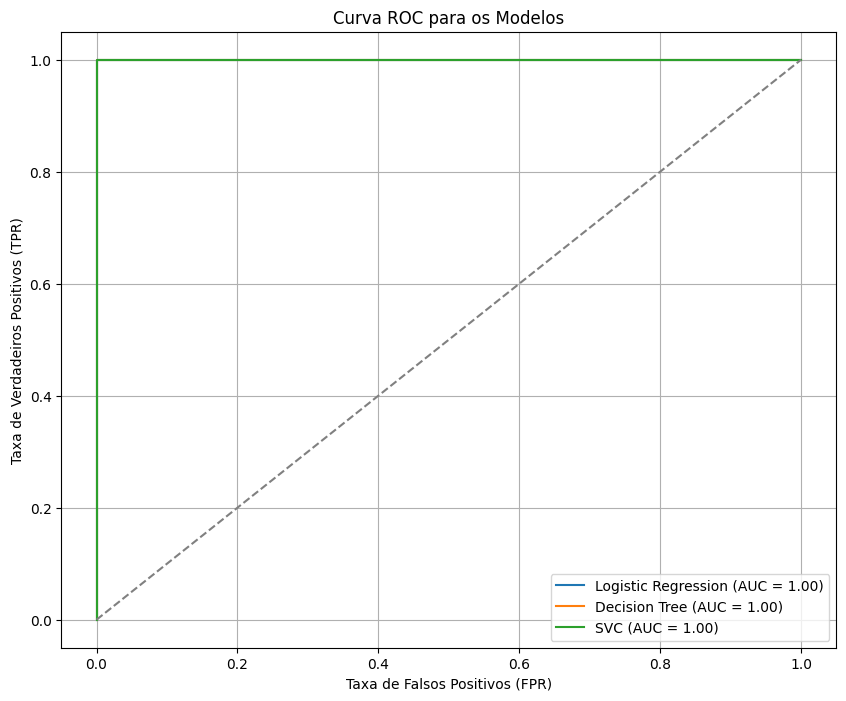

In [168]:
# Função para calcular a curva ROC e AUC
def plot_roc_curve(model, x_train, x_test, y_train, y_test, label):
    # Previsões de probabilidade para a classe positiva (1)
    y_prob = model.predict_proba(x_test)[:, 1]

    # Calculando a curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    # Plotando a curva ROC
    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc:.2f})')

# Logistic Regression
best_logistic_regression = random_search_logistic_regression.best_estimator_
best_logistic_regression.fit(x_train, y_train)

# Decision Tree
best_decision_tree = random_search_decision_three.best_estimator_
best_decision_tree.fit(x_train, y_train)

# SVC
best_svc = random_search_svm.best_estimator_
best_svc.fit(x_train, y_train)

# Plotando a curva ROC para cada modelo
plt.figure(figsize=(10, 8))
plot_roc_curve(best_logistic_regression, x_train, x_test, y_train, y_test, 'Logistic Regression')
plot_roc_curve(best_decision_tree, x_train, x_test, y_train, y_test, 'Decision Tree')
plot_roc_curve(best_svc, x_train, x_test, y_train, y_test, 'SVC')

# Curva ROC do classificador aleatório (linha diagonal)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Títulos e rótulos
plt.title('Curva ROC para os Modelos')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()